In [1]:
from utils import *
import random

/Users/jinanjiang/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
def write_to_file(contents, path):
    with open(path, 'w') as f:
        f.write(contents)
    
def read_from_file(path):
    with open(path) as f:
        return ''.join(f.readlines())
    
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1
    return -9999, -9999

In [3]:
def discover_new_gas_pattern(target_codes, use_cache = False, save_dialogue = False, cache_prefix = 'cache/', collection_mode = False):
    cache_path = cache_prefix
    
    if use_cache and not collection_mode:
        if os.path.exists(cache_path):
            return read_from_file(cache_path)
        
    source_files_lst = []
    
    l = []
    # source_files_lst.append(['prompts_folder/summarize_contracts.txt', "ERC20.sol"])
    l.extend(['gas_new_pattern_prompts/' + 'new_pattern_discovery' + '.txt', GPT_string(target_codes)])
    
    source_files_lst.append(l)

    if save_dialogue:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = get_filename_from_path(contract_file_name) + '_relevant_contracts', do_print = True)
    else:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = None, do_print = True)

    assert len(all_responses_lst) == 1
    
    if use_cache:
        # assert not os.path.exists(cache_path)
        content = all_responses_lst[0]
        content += '\n*****&&&&&^^^^^%%%%%$$$$$\n\n\n'
        write_to_file(content, cache_path)
        
    return all_responses_lst[0]


In [14]:
failed_lst_399023 = []
folder_name_to_list = 'test'
all_files_path_under_folder = os.listdir('crawled_codes/' + folder_name_to_list)

for cur_file_path in all_files_path_under_folder[:5]:
    
    target_codes_path = 'crawled_codes/' + folder_name_to_list + '/' + cur_file_path
    target_codes = read_from_file(target_codes_path)
    
    print(os.path.exists(target_codes_path))
    postfix = read_from_file('gas_new_pattern_prompts/' +  'new_pattern_discovery_postfix.txt')

    
    append_texts = '\n'
    append_texts += target_codes + '\n' + postfix
    append_texts = ''
    
    func_name = cur_file_path.split('.txt')[0]
    gas_pattern_path = 'cache/' + 'GAS_PATTERN_DISCOVERY_' + func_name + '.txt'

    # Note: target codes at CODES_AFTER_CALLED_SIMILAR_FN_
    if os.path.exists(gas_pattern_path):
        print('pre cache_used')
        
    #append_texts = 'hi'
    _, cache_used = discover_new_gas_pattern(append_texts, use_cache = True, cache_prefix = gas_pattern_path, collection_mode = False)


    try:
        _, cache_used = discover_new_gas_pattern(append_texts, use_cache = True, cache_prefix = gas_pattern_path, collection_mode = False)
        #_, cache_used = use_called_and_similar_function_feedback(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_CALLED_SIMILAR_FN_' + func_name + '.txt', collection_mode = False)
    except:
        failed_lst_399023.append(func_name)
        time.sleep(random.randint(30, 60))
        continue
            
    if not cache_used:
        time.sleep(random.randint(30, 60))
    else:
        print('cache_used')
        

True
num_of_contexts:  0

***PROMPT: I want you to help me find new gas-wasting patterns for Solidity at the source code level. To help you accomplish this task, I will give you two types of information, namely a list of known gas-wasting patterns as a few-shot example for you, as well as a chunk of source codes from deployed Solidity codes.

Before giving you the information, I want to tell you a high-level idea of gas optimization. Each instruction in the code sequence consumes a certain amount of gas based on their operation types, which costs money. If we could find an equivalent code instruction sequence that produces the same output while consuming less gas, then this would save money for Solidity users.

Now, the list of known gas-wasting patterns are given below. The list is numbered, with each bullet point specifying one gas-wasting pattern, which is followed by an explanation of why this pattern wastes gas. I want you to read through these and learn how to find new gas-wastin

ValueError: too many values to unpack (expected 2)

In [127]:
codes_path = [f for f in os.listdir('prompts_folder/new_function_dataset_builder/codes_simplified') if f.endswith('sol')]
len(codes_path)

25

In [4]:
# make directories for each code file
for p in codes_path:
    p_name = p.split('.')[0]
    cur_code_path = 'prompts_folder/new_function_dataset_builder/' + p_name
    if not os.path.exists(cur_code_path):
        os.system('mkdir ' + cur_code_path)

In [5]:
def keep_only_signature(func_codes):
    lines = func_codes.split('\n')
    t = []
    starting_ind = 0
    while True:
        assert starting_ind <= len(lines) - 1
        if lines[starting_ind].strip().startswith('function ') or lines[starting_ind].strip().startswith('constructor'):
            break
        else:
            starting_ind += 1
        assert starting_ind <= len(lines) - 1
    
    while True:
        t.append(lines[starting_ind])
        if '{' in lines[starting_ind]:
            assert lines[starting_ind].endswith('{')
            break
        else:
            starting_ind += 1
    return t

In [6]:
def keep_i_func_body(codes_lst_by_func, i):
    new_lst = []
    
    for cur_ind in range(len(codes_lst_by_func)):
        cur_func_codes = codes_lst_by_func[cur_ind]
        if i == cur_ind:
            # keep
            new_lst.extend(cur_func_codes.split('\n'))
            continue
        else:
            # remove function body
            new_lst.extend(keep_only_signature(cur_func_codes))
    return new_lst

In [7]:
def get_function_name(signature):
    if signature.strip().startswith('function '):
        return signature.strip().split(')')[0].split('function ')[1]
    elif  signature.strip().startswith('constructor'):
        return signature.strip().split(')')[0].split('constructor')[1]
    else:
        x = 1/0

In [74]:
f_lst = []
f_count = 0
filename_to_length_map = dict()

for p in codes_path:
    p_name = p.split('.')[0]
    print(p_name)

    
    cur_code_path = 'prompts_folder/new_function_dataset_builder/codes_simplified/' + p
    cur_codes = read_from_file(cur_code_path)
    
    splitted_codes_by_func = cur_codes.split('<FUNCTION_DELIMINATOR_JINAN789>')
    
    prefix_lines = splitted_codes_by_func[0].split('\n')
    splitted_codes_by_func = splitted_codes_by_func[1:]
    for index_func_to_keep in range(len(splitted_codes_by_func)):
        
        target_codes_lines = splitted_codes_by_func[index_func_to_keep].split('\n')
        starting_ind = 0
        while True:
            assert starting_ind <= len(target_codes_lines) - 1
            if target_codes_lines[starting_ind].strip().startswith('function ') or target_codes_lines[starting_ind].strip().startswith('constructor'):
                if target_codes_lines[starting_ind].strip().startswith('constructor'):
                    is_constructor = True
                else:
                    is_constructor = False
                break
            else:
                starting_ind += 1
        
        if is_constructor:
            continue
        func_name = get_function_name(target_codes_lines[starting_ind])
        
        #print((p_name, func_name))
        assert (p_name, func_name) not in filename_to_length_map
        filename_to_length_map[(p_name, func_name, func_name.split('(')[0])] = len([i for i in splitted_codes_by_func[index_func_to_keep].split('\n') if len(i.strip()) > 0 and not i.strip().startswith('*') and not i.strip().startswith('/*')  and not i.strip().startswith('*/')  ])
        
        kept_i_codes = prefix_lines + keep_i_func_body(splitted_codes_by_func, index_func_to_keep)
        kept_i_codes = ''.join([i + '\n' for i in kept_i_codes])
    
        print(func_name)
        f_count += 1
        f_lst.append(func_name)
        
        GPT_prefix = '\n'
        GPT_prefix += 'The function that I want you to summarize is ' + func_name + ', which is defined in the '
        GPT_prefix += 'codes given below. Please note that I have hidden the definition of all other functions, '
        GPT_prefix += 'but I still kept their signatureS, with the purpose of providing richer background information'
        GPT_prefix += ' for you. The codes are: \n'
        
        kept_i_codes = GPT_prefix + kept_i_codes
        write_to_file(kept_i_codes, 'prompts_folder/new_function_dataset_builder/' + p_name + '/SINGLE_FUNCTION_KEPT_' + func_name + '.txt')

Roles
add(Role storage role, address account
remove(Role storage role, address account
has(Role storage role, address account
SafeCast160
toUint160(uint256 value
Exponential
getExp(uint num, uint denom
addExp(Exp memory a, Exp memory b
subExp(Exp memory a, Exp memory b
mulScalar(Exp memory a, uint scalar
mulScalarTruncate(Exp memory a, uint scalar
mulScalarTruncateAddUInt(Exp memory a, uint scalar, uint addend
divScalar(Exp memory a, uint scalar
divScalarByExp(uint scalar, Exp memory divisor
divScalarByExpTruncate(uint scalar, Exp memory divisor
mulExp(Exp memory a, Exp memory b
mulExp(uint a, uint b
mulExp3(Exp memory a, Exp memory b, Exp memory c
divExp(Exp memory a, Exp memory b
CToken
initialize(ComptrollerInterface comptroller_,
transferTokens(address spender, address src, address dst, uint tokens
transfer(address dst, uint256 amount
transferFrom(address src, address dst, uint256 amount
approve(address spender, uint256 amount
allowance(address owner, address spender
balanceOf(addr

add96(uint96 a, uint96 b, string memory errorMessage
sub96(uint96 a, uint96 b, string memory errorMessage
getChainId(
Comp
ErrorReporter2
fail(Error err, FailureInfo info
failOpaque(Error err, FailureInfo info, uint opaqueError
SafeTransferLib
safeTransferETH(address to, uint256 amount
safeTransferFrom(
safeTransfer(
safeApprove(
RewardsCollector
collectRewards(bytes calldata looksRareClaim
LockAndMsgSender
map(address recipient
AddressUpgradeable
isContract(address account
sendValue(address payable recipient, uint256 amount
functionCall(address target, bytes memory data
functionCall(
functionCallWithValue(
functionStaticCall(address target, bytes memory data
functionStaticCall(
verifyCallResult(
UUPSUpgradeable
__UUPSUpgradeable_init(
__UUPSUpgradeable_init_unchained(
upgradeTo(address newImplementation
upgradeToAndCall(address newImplementation, bytes memory data


In [75]:
f_count

254

In [76]:
len(f_lst)

254

In [77]:
len(set(f_lst))

232

In [78]:
filename_to_length_map

{('Roles', 'add(Role storage role, address account', 'add'): 4,
 ('Roles', 'remove(Role storage role, address account', 'remove'): 4,
 ('Roles', 'has(Role storage role, address account', 'has'): 5,
 ('SafeCast160', 'toUint160(uint256 value', 'toUint160'): 5,
 ('Exponential', 'getExp(uint num, uint denom', 'getExp'): 11,
 ('Exponential', 'addExp(Exp memory a, Exp memory b', 'addExp'): 4,
 ('Exponential', 'subExp(Exp memory a, Exp memory b', 'subExp'): 4,
 ('Exponential', 'mulScalar(Exp memory a, uint scalar', 'mulScalar'): 7,
 ('Exponential',
  'mulScalarTruncate(Exp memory a, uint scalar',
  'mulScalarTruncate'): 7,
 ('Exponential',
  'mulScalarTruncateAddUInt(Exp memory a, uint scalar, uint addend',
  'mulScalarTruncateAddUInt'): 7,
 ('Exponential', 'divScalar(Exp memory a, uint scalar', 'divScalar'): 7,
 ('Exponential',
  'divScalarByExp(uint scalar, Exp memory divisor',
  'divScalarByExp'): 13,
 ('Exponential',
  'divScalarByExpTruncate(uint scalar, Exp memory divisor',
  'divScalar

In [79]:
# to count the number of output files

cur_code_path = 'prompts_folder/new_function_dataset_builder/'
l = []
for i in [i for i in os.listdir(cur_code_path) if not i.endswith('.txt') and i != 'codes' and i!= 'codes_simplified' and not i.startswith('.')]:
    l.extend(os.listdir(cur_code_path + i))

In [80]:
# because not all duplicates are in the same folder
len(l)

511

In [128]:
def remove_i_func_body(codes_lst_by_func, i):
    new_lst = []
    
    for cur_ind in range(len(codes_lst_by_func)):
        cur_func_codes = codes_lst_by_func[cur_ind]
        if i == cur_ind:
            # remove
            continue
        else:
            # remove function body
            new_lst.extend(keep_only_signature(cur_func_codes))
    return new_lst

In [129]:
for p in codes_path:
    p_name = p.split('.')[0]
    print(p_name)

    cur_code_path = 'prompts_folder/new_function_dataset_builder/codes_simplified/' + p
    cur_codes = read_from_file(cur_code_path)
    
    splitted_codes_by_func = cur_codes.split('<FUNCTION_DELIMINATOR_JINAN789>')
    
    prefix_lines = splitted_codes_by_func[0].split('\n')
    splitted_codes_by_func = splitted_codes_by_func[1:]
    for index_func_to_keep in range(len(splitted_codes_by_func)):
        
        target_codes_lines = splitted_codes_by_func[index_func_to_keep].split('\n')
        starting_ind = 0
        while True:
            assert starting_ind <= len(target_codes_lines) - 1
            if target_codes_lines[starting_ind].strip().startswith('function ') or target_codes_lines[starting_ind].strip().startswith('constructor'):
                if target_codes_lines[starting_ind].strip().startswith('constructor'):
                    is_constructor = True
                else:
                    is_constructor = False
                break
            else:
                starting_ind += 1
        
        if is_constructor:
            continue
        func_name = get_function_name(target_codes_lines[starting_ind])
        
        kept_i_codes = prefix_lines + remove_i_func_body(splitted_codes_by_func, index_func_to_keep)
        kept_i_codes = ''.join([i + '\n' for i in kept_i_codes])
    
        print(func_name)
        
        GPT_prefix = '\n'
        GPT_prefix += 'The function that I want you to summarize is ' + func_name + ', which is defined in the '
        GPT_prefix += 'codes given below. Please note that I have hidden the definition of all other functions, '
        GPT_prefix += 'but I still kept their signatureS, with the purpose of providing richer background information'
        GPT_prefix += ' for you. The codes are: \n'
        
        kept_i_codes = GPT_prefix + kept_i_codes
        write_to_file(kept_i_codes, 'prompts_folder/new_function_dataset_builder/' + p_name + '/SINGLE_FUNCTION_REMOVED_' + func_name + '.txt')
        
        
        

Roles
add(Role storage role, address account
remove(Role storage role, address account
has(Role storage role, address account
SafeCast160
toUint160(uint256 value
Exponential
getExp(uint num, uint denom
addExp(Exp memory a, Exp memory b
subExp(Exp memory a, Exp memory b
mulScalar(Exp memory a, uint scalar
mulScalarTruncate(Exp memory a, uint scalar
mulScalarTruncateAddUInt(Exp memory a, uint scalar, uint addend
divScalar(Exp memory a, uint scalar
divScalarByExp(uint scalar, Exp memory divisor
divScalarByExpTruncate(uint scalar, Exp memory divisor
mulExp(Exp memory a, Exp memory b
mulExp(uint a, uint b
mulExp3(Exp memory a, Exp memory b, Exp memory c
divExp(Exp memory a, Exp memory b
CToken
initialize(ComptrollerInterface comptroller_,
transferTokens(address spender, address src, address dst, uint tokens
transfer(address dst, uint256 amount
transferFrom(address src, address dst, uint256 amount
approve(address spender, uint256 amount
allowance(address owner, address spender
balanceOf(addr

In [81]:
# deduplication by key
keys = list(filename_to_length_map.keys())
func_name_key_set = set([i[2] for i in keys])

In [82]:
len(func_name_key_set)

190

In [83]:
func_name_to_file_pair_map = dict()
for name in func_name_key_set:
    matches = [(i, filename_to_length_map[i]) for i in keys if i[2] == name]
    ideal_key = sorted(matches, key = lambda x: -x[1])[0]
    func_name_to_file_pair_map[name] = ideal_key

In [84]:
func_name_to_file_pair_map

{'divScalarByExp': (('Exponential',
   'divScalarByExp(uint scalar, Exp memory divisor',
   'divScalarByExp'),
  13),
 '_setReserveFactor': (('CToken',
   '_setReserveFactor(uint newReserveFactorMantissa',
   '_setReserveFactor'),
  9),
 '_acceptImplementation': (('Unitroller',
   '_acceptImplementation(',
   '_acceptImplementation'),
  14),
 'functionCall': (('AddressUpgradeable', 'functionCall(', 'functionCall'), 8),
 'liquidateBorrowFresh': (('CToken',
   'liquidateBorrowFresh(address liquidator, address borrower, uint repayAmount, CTokenInterface cTokenCollateral',
   'liquidateBorrowFresh'),
  43),
 '__UUPSUpgradeable_init': (('UUPSUpgradeable',
   '__UUPSUpgradeable_init(',
   '__UUPSUpgradeable_init'),
  4),
 'updateOneInchAddress': (('Pool',
   'updateOneInchAddress(address newOneInch',
   'updateOneInchAddress'),
  4),
 'divExp': (('Exponential', 'divExp(Exp memory a, Exp memory b', 'divExp'), 4),
 'removeFromWhitelist': (('INV',
   'removeFromWhitelist(address _user',
   'rem

In [85]:
for file_name in func_name_to_file_pair_map:
    ideal_key = func_name_to_file_pair_map[file_name][0]
    
    p_name = ideal_key[0]
    signature = ideal_key[1]
    func_name = ideal_key[2]
    
    
    contents = read_from_file('prompts_folder/new_function_dataset_builder/' + p_name + '/SINGLE_FUNCTION_KEPT_' + signature + '.txt')
    
    write_to_file(contents, 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SINGLE_FUNCTION_KEPT_' + func_name + '.txt')


In [130]:
for file_name in func_name_to_file_pair_map:
    ideal_key = func_name_to_file_pair_map[file_name][0]
    
    p_name = ideal_key[0]
    signature = ideal_key[1]
    func_name = ideal_key[2]
    
    
    contents = read_from_file('prompts_folder/new_function_dataset_builder/' + p_name + '/SINGLE_FUNCTION_REMOVED_' + signature + '.txt')
    
    write_to_file(contents, 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SINGLE_FUNCTION_REMOVED_' + func_name + '.txt')


In [95]:

p_fun_name_pair_records = dict()

for file_name in func_name_to_file_pair_map:
    ideal_key = func_name_to_file_pair_map[file_name][0]
    
    p_name = ideal_key[0]
    signature = ideal_key[1]
    func_name = ideal_key[2]
    print(func_name)

divScalarByExp
_setReserveFactor
_acceptImplementation
functionCall
liquidateBorrowFresh
__UUPSUpgradeable_init
updateOneInchAddress
divExp
removeFromWhitelist
_authorizeUpgrade
seizeInternal
borrowRatePerBlock
map
_setInterestRateModel
addDao
_getAdmin
_setImplementation
_setProposalThreshold
getBlockNumber
remove
getCurrentVotes
redeemUnderlyingInternal
_initiate
addToWhitelist
_moveDelegates
getChainId
mintFresh
add96
_AcceptTimelockAdmin
divScalarByExpTruncate
mul_
state
exchangeRateStored
addThenSubUInt
redeemInternal
tryMul
_getDecimals
renounceDao
trySub
isWhitelisted
has
greaterThanExp
divScalar
liquidateBorrowInternal
_functionDelegateCall
borrowBalanceStored
_calcRateFromQty
supplyRatePerBlock
getExp
subExp
_setInterestRateModelFresh
__UUPSUpgradeable_init_unchained
addExp
redeemFresh
queueOrRevertInternal
repayBorrowInternal
repayBorrowFresh
safe224
_acceptAdmin
_getBeacon
_delegate
_setBeacon
_reduceReservesFresh
functionStaticCall
failOpaque
_callOptionalReturn
balanceOf
s

In [86]:
# sort all files by LOC
sorted_all_by_length = sorted(list(func_name_to_file_pair_map.items()), key = lambda x : -x[1][1])

In [179]:
len([i[1][1] for i in sorted_all_by_length if i[1][1] >= 11])

53

In [180]:
list_of_long_enough_functions = [i[0] for i in sorted_all_by_length if i[1][1] >= 11]

In [181]:
len(list_of_long_enough_functions)

53

In [182]:
func_name_to_file_pair_map

{'divScalarByExp': (('Exponential',
   'divScalarByExp(uint scalar, Exp memory divisor',
   'divScalarByExp'),
  13),
 '_setReserveFactor': (('CToken',
   '_setReserveFactor(uint newReserveFactorMantissa',
   '_setReserveFactor'),
  9),
 '_acceptImplementation': (('Unitroller',
   '_acceptImplementation(',
   '_acceptImplementation'),
  14),
 'functionCall': (('AddressUpgradeable', 'functionCall(', 'functionCall'), 8),
 'liquidateBorrowFresh': (('CToken',
   'liquidateBorrowFresh(address liquidator, address borrower, uint repayAmount, CTokenInterface cTokenCollateral',
   'liquidateBorrowFresh'),
  43),
 '__UUPSUpgradeable_init': (('UUPSUpgradeable',
   '__UUPSUpgradeable_init(',
   '__UUPSUpgradeable_init'),
  4),
 'updateOneInchAddress': (('Pool',
   'updateOneInchAddress(address newOneInch',
   'updateOneInchAddress'),
  4),
 'divExp': (('Exponential', 'divExp(Exp memory a, Exp memory b', 'divExp'), 4),
 'removeFromWhitelist': (('INV',
   'removeFromWhitelist(address _user',
   'rem

In [175]:
# 
p_fun_name_pair_records = dict()

for file_name in func_name_to_file_pair_map:
    
    ideal_key = func_name_to_file_pair_map[file_name][0]
    
    p_name = ideal_key[0]
    signature = ideal_key[1]
    func_name = ideal_key[2]
    
    
    if (p_name, func_name) not in p_fun_name_pair_records:
        p_fun_name_pair_records[(p_name, func_name)] = []
    p_fun_name_pair_records[(p_name, func_name)].append(ideal_key) 

for k in p_fun_name_pair_records:
    p_fun_name_pair_records[k] = len(p_fun_name_pair_records[k])

In [176]:
p_fun_name_pair_records

{('Exponential', 'divScalarByExp'): 1,
 ('CToken', '_setReserveFactor'): 1,
 ('Unitroller', '_acceptImplementation'): 1,
 ('AddressUpgradeable', 'functionCall'): 1,
 ('CToken', 'liquidateBorrowFresh'): 1,
 ('UUPSUpgradeable', '__UUPSUpgradeable_init'): 1,
 ('Pool', 'updateOneInchAddress'): 1,
 ('Exponential', 'divExp'): 1,
 ('INV', 'removeFromWhitelist'): 1,
 ('governance', '_authorizeUpgrade'): 1,
 ('CToken', 'seizeInternal'): 1,
 ('CToken', 'borrowRatePerBlock'): 1,
 ('LockAndMsgSender', 'map'): 1,
 ('CToken', '_setInterestRateModel'): 1,
 ('Dao', 'addDao'): 1,
 ('ERC1967UpgradeUpgradeable', '_getAdmin'): 1,
 ('ERC1967UpgradeUpgradeable', '_setImplementation'): 1,
 ('governance', '_setProposalThreshold'): 1,
 ('CToken', 'getBlockNumber'): 1,
 ('Roles', 'remove'): 1,
 ('INV', 'getCurrentVotes'): 1,
 ('CToken', 'redeemUnderlyingInternal'): 1,
 ('governance', '_initiate'): 1,
 ('INV', 'addToWhitelist'): 1,
 ('INV', '_moveDelegates'): 1,
 ('INV', 'getChainId'): 1,
 ('CToken', 'mintFresh'

In [107]:
# copy over the old summaries to save API calls

for file_name in func_name_to_file_pair_map:
    
    if file_name not in list_of_long_enough_functions:
        continue
    
    
    ideal_key = func_name_to_file_pair_map[file_name][0]
    
    p_name = ideal_key[0]
    signature = ideal_key[1]
    func_name = ideal_key[2]
    
    if p_fun_name_pair_records[(p_name, func_name)] != 1:
        # not safe to copy
        continue
    
    
    old_path = 'prompts_folder/function_dataset_builder/' + p_name + '/' + func_name + '_cache.txt'
    if os.path.exists(old_path):
        old_contents = read_from_file(old_path)
        
        write_to_file(old_contents, 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SUMMARIZED_' + func_name + '.txt')



In [108]:
now_files_lst = os.listdir('prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/')
len([i for i in now_files_lst if i.startswith('SUMMARIZED_')])

26

In [109]:
len([i for i in now_files_lst if i.startswith('SINGLE_FUNCTION')])

190

In [56]:
openai.api_key = "8b116907e4144bbf90b7e15d56e54938"

In [57]:
# make up the missing summaries

def summarize_functions(input_codes, use_cache = False, save_dialogue = False, cache_prefix = 'cache/', collection_mode = False):
    cache_path = cache_prefix
    
    if use_cache and not collection_mode:
        if os.path.exists(cache_path):
            return read_from_file(cache_path), True
        
    source_files_lst = []
        
    l = []
    # source_files_lst.append(['prompts_folder/summarize_contracts.txt', "ERC20.sol"])
    l.extend(['prompts_folder/new_function_dataset_builder/' + 'summarize_functions_dataset_builder' + '.txt', GPT_string(input_codes)])
    
    source_files_lst.append(l)

    if save_dialogue:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = get_filename_from_path(contract_file_name) + '_relevant_contracts', do_print = True)
    else:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = None, do_print = True)

    assert len(all_responses_lst) == 1
    
    if use_cache:
        # assert not os.path.exists(cache_path)
        content = all_responses_lst[0]
        write_to_file(content, cache_path)
        
    return all_responses_lst[0], False



In [124]:
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
    
    print(func_name) 
    cur_code_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SINGLE_FUNCTION_KEPT_' + func_name + '.txt'
    cur_codes = read_from_file(cur_code_path)
    
    target_summary_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SUMMARIZED_' + func_name + '.txt'
    
    if os.path.exists(target_summary_path):
        print('pre cache_used')

    _, cache_used = summarize_functions(cur_codes, use_cache = True, cache_prefix = target_summary_path, collection_mode = False)

    if not cache_used:
        time.sleep(random.randint(30, 60))
    else:
        print('cache_used')
        

divScalarByExp
pre cache_used
cache_used
_acceptImplementation
pre cache_used
cache_used
liquidateBorrowFresh
pre cache_used
cache_used
seizeInternal
pre cache_used
cache_used
_moveDelegates
pre cache_used
cache_used
mintFresh
pre cache_used
cache_used
state
pre cache_used
cache_used
tryMul
pre cache_used
cache_used
liquidateBorrowInternal
pre cache_used
cache_used
_calcRateFromQty
pre cache_used
cache_used
getExp
pre cache_used
cache_used
_setInterestRateModelFresh
pre cache_used
cache_used
redeemFresh
pre cache_used
cache_used
repayBorrowFresh
pre cache_used
cache_used
_acceptAdmin
pre cache_used
cache_used
_reduceReservesFresh
pre cache_used
cache_used
_callOptionalReturn
pre cache_used
cache_used
safeDecreaseAllowance
pre cache_used
cache_used
castVoteInternal
pre cache_used
cache_used
dispatch
pre cache_used
cache_used
propose
pre cache_used
cache_used
initialize
pre cache_used
cache_used
functionCallWithValue
pre cache_used
cache_used
verifyCallResult
pre cache_used
cache_used
bo

In [110]:
# copy over the old generations to save API calls

for file_name in func_name_to_file_pair_map:
    
    if file_name not in list_of_long_enough_functions:
        continue
    
    
    ideal_key = func_name_to_file_pair_map[file_name][0]
    
    p_name = ideal_key[0]
    signature = ideal_key[1]
    func_name = ideal_key[2]
    
    if p_fun_name_pair_records[(p_name, func_name)] != 1:
        # not safe to copy
        continue
    
    
    old_path = 'prompts_folder/function_dataset_builder/' + p_name + '/' + func_name + 'filled_in_codes_cache.txt'
    if os.path.exists(old_path):
        old_contents = read_from_file(old_path)
        
        write_to_file(old_contents, 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'DIRECT_GENERATED_' + func_name + '.txt')



In [137]:
now_files_lst = os.listdir('prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/')
len([i for i in now_files_lst if i.startswith('DIRECT_GENERATED_')])

43

In [131]:
def fill_in_missing_functions(append_texts, use_cache = False, save_dialogue = False, cache_prefix = 'cache/', collection_mode = False):
    cache_path = cache_prefix
    
    if use_cache and not collection_mode:
        if os.path.exists(cache_path):
            return read_from_file(cache_path), True
        
    source_files_lst = []
        
    l = []
    # source_files_lst.append(['prompts_folder/summarize_contracts.txt', "ERC20.sol"])
    l.extend(['prompts_folder/new_function_dataset_builder/' + 'generate_missing_codes' + '.txt', GPT_string(append_texts)])
    
    source_files_lst.append(l)

    if save_dialogue:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = get_filename_from_path(contract_file_name) + '_relevant_contracts', do_print = True)
    else:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = None, do_print = True)

    assert len(all_responses_lst) == 1
    
    if use_cache:
        # assert not os.path.exists(cache_path)
        content = all_responses_lst[0]
        write_to_file(content, cache_path)
        
    return all_responses_lst[0], False



In [248]:
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    print(func_name) 
    cur_code_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SINGLE_FUNCTION_REMOVED_' + func_name + '.txt'
    cur_codes = read_from_file(cur_code_path)
    
    cur_summary_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SUMMARIZED_' + func_name + '.txt'
    cur_summary = read_from_file(cur_summary_path)

    target_generation_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'DIRECT_GENERATED_' + func_name + '.txt'

    
    if os.path.exists(target_generation_path):
        print('pre cache_used')

    append_texts = '\n'
    
    append_texts += 'Here are the codes of the contract for which you will write a new function:\n'
    append_texts += cur_codes + '\n\n'

    append_texts += 'The summary of the function that I want you to add is given below:\n'
    append_texts += cur_summary

    _, cache_used = fill_in_missing_functions(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'DIRECT_GENERATED_' + func_name + '.txt', collection_mode = False)

            
    if not cache_used:
        time.sleep(random.randint(30, 60))
    else:
        print('cache_used')
        

divScalarByExp
pre cache_used
cache_used
_acceptImplementation
pre cache_used
cache_used
liquidateBorrowFresh
pre cache_used
cache_used
seizeInternal
pre cache_used
cache_used
_moveDelegates
pre cache_used
cache_used
mintFresh
pre cache_used
cache_used
state
pre cache_used
cache_used
tryMul
pre cache_used
cache_used
liquidateBorrowInternal
pre cache_used
cache_used
_calcRateFromQty
pre cache_used
cache_used
getExp
pre cache_used
cache_used
_setInterestRateModelFresh
pre cache_used
cache_used
redeemFresh
pre cache_used
cache_used
repayBorrowFresh
pre cache_used
cache_used
_acceptAdmin
pre cache_used
cache_used
_reduceReservesFresh
pre cache_used
cache_used
_callOptionalReturn
pre cache_used
cache_used
safeDecreaseAllowance
pre cache_used
cache_used
castVoteInternal
pre cache_used
cache_used
dispatch
pre cache_used
cache_used
propose
pre cache_used
cache_used
initialize
pre cache_used
cache_used
functionCallWithValue
pre cache_used
cache_used
verifyCallResult
pre cache_used
cache_used
bo

In [249]:
# trim out deliminators and comments
for file_name in func_name_to_file_pair_map:
    
    if file_name not in list_of_long_enough_functions:
        continue
        
    code_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'DIRECT_GENERATED_' + file_name + '.txt'
    codes = read_from_file(code_path)
    
    codes = codes.split('\n')
    
    if '<CODE_BEGINNING>' not in codes:
        print(file_name, ' FAILED')
        continue
        
    ind = codes.index('<CODE_BEGINNING>')
    while True:
        if codes[ind].strip().startswith('function '):
            break
        else:
            ind += 1

    ending_ind = codes.index('<CODE_ENDING>')
    codes = ''.join([i + '\n' for i in codes[ind:ending_ind]])

    write_to_file(codes, code_path)



divScalarByExp  FAILED
_acceptImplementation  FAILED
liquidateBorrowFresh  FAILED
_moveDelegates  FAILED
mintFresh  FAILED
state  FAILED
tryMul  FAILED
liquidateBorrowInternal  FAILED
_calcRateFromQty  FAILED
getExp  FAILED
_setInterestRateModelFresh  FAILED
redeemFresh  FAILED
repayBorrowFresh  FAILED
_acceptAdmin  FAILED
_reduceReservesFresh  FAILED
_callOptionalReturn  FAILED
safeDecreaseAllowance  FAILED
castVoteInternal  FAILED
dispatch  FAILED
propose  FAILED
initialize  FAILED
functionCallWithValue  FAILED
verifyCallResult  FAILED
borrowFresh  FAILED
callAndTransfer721  FAILED
mulExp  FAILED
getAccountSnapshot  FAILED
safeTransferFrom  FAILED
_setPendingAdmin  FAILED
transferTokens  FAILED
mulUInt  FAILED
_upgradeToAndCallSecure  FAILED
_addReservesFresh  FAILED
getPriorVotes  FAILED
borrowBalanceStoredInternal  FAILED
_setReserveFactorFresh  FAILED
safeTransfer  FAILED
permit  FAILED
accrueInterest  FAILED
_transferTokens  FAILED
mul  FAILED
mod  FAILED
callAndTransfer1155  FAI

In [157]:
def COT_feedback_correction(append_texts, use_cache = False, save_dialogue = False, cache_prefix = 'cache/', collection_mode = False):
    cache_path = cache_prefix
    
    if use_cache and not collection_mode:
        if os.path.exists(cache_path):
            return read_from_file(cache_path), True
        
    source_files_lst = []
        
    l = []
    # source_files_lst.append(['prompts_folder/summarize_contracts.txt', "ERC20.sol"])
    l.extend(['prompts_folder/new_function_dataset_builder/' + 'COT_feedback_and_update' + '.txt', GPT_string(append_texts)])
    
    source_files_lst.append(l)

    if save_dialogue:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = get_filename_from_path(contract_file_name) + '_relevant_contracts', do_print = True)
    else:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = None, do_print = True)

    assert len(all_responses_lst) == 1
    
    if use_cache:
        # assert not os.path.exists(cache_path)
        content = all_responses_lst[0]
        write_to_file(content, cache_path)
        
    return all_responses_lst[0], False



In [260]:
failed_lst111 = ['seizeInternal', 'state', 'dispatch', 'borrowFresh', 'swap']
# failed_lst111_complete = ['initialize', 'borrowFresh', 'swap', 'mintFresh', 'state', 'repayBorrowFresh', '_callOptionalReturn', 'dispatch', 'propose']
# Using GPT-4 POE failed_lst111 = ['seizeInternal', 'state', 'dispatch', 'borrowFresh', 'swap']


for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    if func_name != failed_lst111[4]:
        continue
        
    print(func_name) 
    cur_code_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SINGLE_FUNCTION_REMOVED_' + func_name + '.txt'
    cur_codes = read_from_file(cur_code_path)
    cur_codes = cur_codes.split('The codes are: \n')[1]

    cur_summary_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SUMMARIZED_' + func_name + '.txt'
    cur_summary = read_from_file(cur_summary_path)

    target_generation_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'DIRECT_GENERATED_' + func_name + '.txt'
    generated_codes = read_from_file(target_generation_path)
    
    
    append_texts = '\n'
    
    append_texts += 'Information 1: The function codes that I wrote are intended to be added to the following contract:\n'
    append_texts += cur_codes + '\n\n'
    
    append_texts += 'Information 2: Here is a summary of the function codes (including the funcion input/output and a brief summary of the intended functionalities) that I were supposed to follow when writing the codes:\n'
    append_texts += cur_summary + '\n\n'
    
    append_texts += 'Information 3: Here are the codes that I wrote for this task:\n'
    append_texts += generated_codes + '\n\n'
    
    
    append_texts += 'Now that I have given you all the necessary information, please help me perform the following two tasks:\n'

    append_texts += 'TASK 1: By using Information 1 and 2, I want you to think step by step about the task, and give me a'
    append_texts += 'step-by-step plan of how to perform the functionality described in the provided summaries, under the'
    append_texts += 'context of the contract from Information 1. Please be reminded that this plan should contain the exact'
    append_texts += 'steps to be taken, in a logical and coherent manner.\n'


    append_texts += 'Then please use this plan to perform improvements on the codes I wrote and gave you. Specifically,'
    append_texts += ' please check if each of the steps is present in the given codes in the correct order; if not,'
    append_texts += ' please help me make updates to the given codes to make sure each of the steps to solving this '
    append_texts += 'problem is present in the codes in a logical and coherent way.'
    
    
    print(read_from_file('prompts_folder/new_function_dataset_builder/' + 'COT_feedback_and_update' + '.txt'))
    print(append_texts)
    break
    
    target_COT_feedback_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'COT_FEEDBACK_CORRECTED_' + func_name + '.txt'

    if os.path.exists(target_COT_feedback_path):
        print('pre cache_used')

    try:
        _, cache_used = COT_feedback_correction(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'COT_FEEDBACK_CORRECTED_' + func_name + '.txt', collection_mode = False)
    except:
        failed_lst111.append(func_name)
        time.sleep(random.randint(30, 60))
        continue
            
    if not cache_used:
        time.sleep(random.randint(30, 60))
    else:
        print('cache_used')
        

swap
I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.



Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: Unlicensed
pragma solidity ^0.8.0;

import '@openzeppelin/contracts/utils/math/SafeMath.sol';
import '@openzeppelin/contracts/token/ERC20/utils/SafeERC20.sol';
import './access/roles/Admin.sol';
import './access/roles/Dao.sol';
import './interfaces

In [251]:
failed_lst111

['seizeInternal', 'state', 'dispatch', 'borrowFresh', 'swap']

In [255]:
def find_few_shot_example_to_sigs(append_texts, use_cache = False, save_dialogue = False, cache_prefix = 'cache/', collection_mode = False):
    cache_path = cache_prefix
    
    if use_cache and not collection_mode:
        if os.path.exists(cache_path):
            return read_from_file(cache_path), True
        
    source_files_lst = []
        
    l = []
    # source_files_lst.append(['prompts_folder/summarize_contracts.txt', "ERC20.sol"])
    l.extend(['prompts_folder/new_function_dataset_builder/' + 'few_shot_example_lookup' + '.txt', GPT_string(append_texts)])
    
    source_files_lst.append(l)

    if save_dialogue:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = get_filename_from_path(contract_file_name) + '_relevant_contracts', do_print = True)
    else:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = None, do_print = True)

    assert len(all_responses_lst) == 1
    
    if use_cache:
        # assert not os.path.exists(cache_path)
        content = all_responses_lst[0]
        write_to_file(content, cache_path)
        
    return all_responses_lst[0], False



In [282]:
failed_lst2222 = []


In [285]:
failed_lst2222

[]

In [384]:
func_name_key_set

{'_AcceptTimelockAdmin',
 '__ERC1967Upgrade_init',
 '__ERC1967Upgrade_init_unchained',
 '__UUPSUpgradeable_init',
 '__UUPSUpgradeable_init_unchained',
 '_acceptAdmin',
 '_acceptImplementation',
 '_addDao',
 '_addReservesFresh',
 '_addReservesInternal',
 '_authorizeUpgrade',
 '_calcRateFromQty',
 '_callOptionalReturn',
 '_changeAdmin',
 '_delegate',
 '_functionDelegateCall',
 '_fundInvestee',
 '_getAdmin',
 '_getBalance',
 '_getBeacon',
 '_getDecimals',
 '_getImplementation',
 '_initiate',
 '_moveDelegates',
 '_oneInchTrade',
 '_reduceReserves',
 '_reduceReservesFresh',
 '_removeDao',
 '_setAdmin',
 '_setBeacon',
 '_setComptroller',
 '_setImplementation',
 '_setInterestRateModel',
 '_setInterestRateModelFresh',
 '_setInvesteeDetails',
 '_setPendingAdmin',
 '_setPendingImplementation',
 '_setProposalThreshold',
 '_setReserveFactor',
 '_setReserveFactorFresh',
 '_setVotingDelay',
 '_setVotingPeriod',
 '_setWhitelistAccountExpiration',
 '_setWhitelistGuardian',
 '_transferTokens',
 '_upgra

In [385]:
list_of_long_enough_functions

['dispatch',
 'redeemFresh',
 'accrueInterest',
 '_oneInchTrade',
 'liquidateBorrowFresh',
 'transferTokens',
 'seizeInternal',
 'propose',
 'borrowFresh',
 'repayBorrowFresh',
 '_reduceReservesFresh',
 'mintFresh',
 'swap',
 'safeTransferFrom',
 '_upgradeToAndCallSecure',
 'getPriorVotes',
 'safeApprove',
 'safeTransfer',
 'initialize',
 '_setInterestRateModelFresh',
 'state',
 'verifyCallResult',
 'castVoteInternal',
 'callAndTransfer1155',
 'exchangeRateStoredInternal',
 '_addReservesFresh',
 '_calcRateFromQty',
 'callAndTransfer721',
 'borrowBalanceStoredInternal',
 '_setReserveFactorFresh',
 '_acceptAdmin',
 'mulExp',
 'permit',
 '_moveDelegates',
 'getAccountSnapshot',
 '_acceptImplementation',
 'liquidateBorrowInternal',
 '_setComptroller',
 'divScalarByExp',
 '_setPendingAdmin',
 'safeDecreaseAllowance',
 'mod',
 'mint',
 'transferFrom',
 'tryMul',
 'getExp',
 '_callOptionalReturn',
 'functionCallWithValue',
 'mulUInt',
 '_transferTokens',
 'mul',
 '_upgradeBeaconToAndCall',
 '

In [284]:
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
        
    print(func_name) 
    cur_code_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SINGLE_FUNCTION_REMOVED_' + func_name + '.txt'
    cur_codes = read_from_file(cur_code_path)
    cur_codes = cur_codes.split('The codes are: \n')[1]

    target_generation_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'DIRECT_GENERATED_' + func_name + '.txt'
    generated_codes = read_from_file(target_generation_path)
    
    append_texts = '\n'
    
    append_texts += 'To begin with, the contract that contains the list of function signatures for you to select from is given below:\n'
    append_texts += cur_codes + '\n\n'
    
    append_texts += 'Next, here is the implementation of the target function for which I want you to match similar function signatures:\n'
    append_texts += generated_codes + '\n\n'
    
    append_texts += 'Now that you have all of the information, please help me find out which of the given function signatures (no more than 2)'
    append_texts += ' would have the most similar functionality to the given target function.'
    
    
    
    found_few_shot_example_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'FOUND_FEW_SHOT_EXAMPLE' + func_name + '.txt'

    if os.path.exists(found_few_shot_example_path):
        print('pre cache_used')


    try:
        _, cache_used = find_few_shot_example_to_sigs(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'FOUND_FEW_SHOT_EXAMPLE' + func_name + '.txt', collection_mode = False)
    except:
        failed_lst2222.append(func_name)
        time.sleep(random.randint(30, 60))
        continue
        
            
    if not cache_used:
        time.sleep(random.randint(30, 60))
    else:
        print('cache_used')
        

divScalarByExp
pre cache_used
cache_used
_acceptImplementation
pre cache_used
cache_used
liquidateBorrowFresh
pre cache_used
cache_used
seizeInternal
pre cache_used
cache_used
_moveDelegates
pre cache_used
cache_used
mintFresh
pre cache_used
cache_used
state
pre cache_used
cache_used
tryMul
pre cache_used
cache_used
liquidateBorrowInternal
pre cache_used
cache_used
_calcRateFromQty
pre cache_used
cache_used
getExp
pre cache_used
cache_used
_setInterestRateModelFresh
pre cache_used
cache_used
redeemFresh
pre cache_used
cache_used
repayBorrowFresh
pre cache_used
cache_used
_acceptAdmin
pre cache_used
cache_used
_reduceReservesFresh
pre cache_used
cache_used
_callOptionalReturn
pre cache_used
cache_used
safeDecreaseAllowance
pre cache_used
cache_used
castVoteInternal
pre cache_used
cache_used
dispatch
pre cache_used
cache_used
propose
pre cache_used
cache_used
initialize
pre cache_used
cache_used
functionCallWithValue
pre cache_used
cache_used
verifyCallResult
pre cache_used
cache_used
bo

In [286]:
# some basic sanity checks
func_to_contract_name_map = dict()
for func_name in func_name_key_set:
    print(func_name)
    cur_code_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SINGLE_FUNCTION_REMOVED_' + func_name + '.txt'
    cur_codes = read_from_file(cur_code_path)
    
    cur_codes = cur_codes.split('\n')
    cont_candidates = [i for i in cur_codes if i.strip().startswith('contract ') or i.strip().startswith('abstract contract ') or i.strip().startswith('library ')]
    if len(cont_candidates) != 1:
        print(func_name) 
        print(cont_candidates)
        1/0
    else:
        c = cont_candidates[0].strip()
        if c.startswith('contract '):
            c = c[9:]
        elif c.startswith('abstract contract '):
            c = c[18:]
        elif c.startswith('library '):
            c = c[8:]
        c_t = c.split(' ')
        assert len(c_t) > 1
        c = c_t[0]
        
        if c == 'GovernorBravoDelegate':
            c = 'governance'
        func_to_contract_name_map[func_name] = c
    
    

divScalarByExp
_setReserveFactor
_acceptImplementation
functionCall
liquidateBorrowFresh
__UUPSUpgradeable_init
updateOneInchAddress
divExp
removeFromWhitelist
_authorizeUpgrade
seizeInternal
borrowRatePerBlock
map
_setInterestRateModel
addDao
_getAdmin
_setImplementation
_setProposalThreshold
getBlockNumber
remove
getCurrentVotes
redeemUnderlyingInternal
_initiate
addToWhitelist
_moveDelegates
getChainId
mintFresh
add96
_AcceptTimelockAdmin
divScalarByExpTruncate
mul_
state
exchangeRateStored
addThenSubUInt
redeemInternal
tryMul
_getDecimals
renounceDao
trySub
isWhitelisted
has
greaterThanExp
divScalar
liquidateBorrowInternal
_functionDelegateCall
borrowBalanceStored
_calcRateFromQty
supplyRatePerBlock
getExp
subExp
_setInterestRateModelFresh
__UUPSUpgradeable_init_unchained
addExp
redeemFresh
queueOrRevertInternal
repayBorrowInternal
repayBorrowFresh
safe224
_acceptAdmin
_getBeacon
_delegate
_setBeacon
_reduceReservesFresh
functionStaticCall
failOpaque
_callOptionalReturn
balanceOf
s

In [287]:
func_to_contract_name_map

{'divScalarByExp': 'Exponential',
 '_setReserveFactor': 'CToken',
 '_acceptImplementation': 'Unitroller',
 'functionCall': 'AddressUpgradeable',
 'liquidateBorrowFresh': 'CToken',
 '__UUPSUpgradeable_init': 'UUPSUpgradeable',
 'updateOneInchAddress': 'Pool',
 'divExp': 'Exponential',
 'removeFromWhitelist': 'INV',
 '_authorizeUpgrade': 'governance',
 'seizeInternal': 'CToken',
 'borrowRatePerBlock': 'CToken',
 'map': 'LockAndMsgSender',
 '_setInterestRateModel': 'CToken',
 'addDao': 'DaoRole',
 '_getAdmin': 'ERC1967UpgradeUpgradeable',
 '_setImplementation': 'ERC1967UpgradeUpgradeable',
 '_setProposalThreshold': 'governance',
 'getBlockNumber': 'CToken',
 'remove': 'Roles',
 'getCurrentVotes': 'INV',
 'redeemUnderlyingInternal': 'CToken',
 '_initiate': 'governance',
 'addToWhitelist': 'INV',
 '_moveDelegates': 'INV',
 'getChainId': 'INV',
 'mintFresh': 'CToken',
 'add96': 'INV',
 '_AcceptTimelockAdmin': 'governance',
 'divScalarByExpTruncate': 'Exponential',
 'mul_': 'ExponentialNoErro

In [314]:
# extract the found few shot examples from the original contract

def get_few_shot_ex_actual_implementations(func_name):
    cur_code_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'FOUND_FEW_SHOT_EXAMPLE' + func_name + '.txt'
    
    try:
        found_few_shot_examples = read_from_file(cur_code_path)

        first_example = [i for i in found_few_shot_examples.split('\n') if i.strip().startswith('1.')]
        second_example = [i for i in found_few_shot_examples.split('\n') if i.strip().startswith('2.')]

        assert len(first_example) == 1
        assert len(second_example) == 1
        
        # TODO: here we need to match by exact lines (to prevent mul-line signatures)

        first_example = ''.join([i for i in first_example[0] if i != '`'])
        second_example = ''.join([i for i in second_example[0] if i != '`'])
        
        print(first_example)
        print(second_example)

        first_example = first_example[first_example.index('function '):]
        second_example = second_example[second_example.index('function '):]

        original_contract_path = 'prompts_folder/new_function_dataset_builder/codes_simplified/' + func_to_contract_name_map[func_name] + '.sol'
        contract_codes = read_from_file(original_contract_path).split('\n')

        first_example_ind = [i for i in contract_codes if i.strip().startswith(first_example)]
        assert len(first_example_ind) == 1
        second_example_ind = [i for i in contract_codes if i.strip().startswith(second_example)]
        assert len(second_example_ind) == 1

        first_example_ind = contract_codes.index(first_example_ind[0])
        second_example_ind = contract_codes.index(second_example_ind[0])

        #print(first_example_ind, second_example_ind)
        first_codes_full_body = [contract_codes[first_example_ind]]
        for line in contract_codes[first_example_ind + 1:]:
            if line.strip().startswith('<FUNCTION_DELIMINATOR_JINAN789>'):
                break
            else:
                first_codes_full_body.append(line)
                
        first_codes_full_body = ''.join([i+'\n' for i in first_codes_full_body])
                
        second_codes_full_body = [contract_codes[second_example_ind]]
        for line in contract_codes[second_example_ind + 1:]:
            if line.strip().startswith('<FUNCTION_DELIMINATOR_JINAN789>'):
                break
            else:
                second_codes_full_body.append(line)
               
        second_codes_full_body = ''.join([i+'\n' for i in second_codes_full_body])
        
        return first_codes_full_body + second_codes_full_body
    except FileNotFoundError:
        print(func_name, ": NOT FOUND!!!!!!")
        return None




In [280]:
func_to_contract_name_map['propose']

'governance'

In [345]:
f99999

[]

In [344]:
f99999 = []
c = 0

for func_name in func_name_key_set:

    if func_name in f99999:
        continue
        
    if func_name not in list_of_long_enough_functions:
        continue
    
    found_two_examples = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'TWO_SHOT_EXAMPLES_BODY_' + func_name + '.txt'
    print(found_two_examples)
    print(os.path.exists(found_two_examples))
    if os.path.exists(found_two_examples):
        continue
        break

    print(func_name)
    continue
    try:
        examples_body = get_few_shot_ex_actual_implementations(func_name)
        if examples_body is not None:
            c += 1
            write_to_file(examples_body, found_two_examples)
    except:
        f99999.append(func_name)
        


prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_SHOT_EXAMPLES_BODY_divScalarByExp.txt
True
prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_SHOT_EXAMPLES_BODY__acceptImplementation.txt
True
prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_SHOT_EXAMPLES_BODY_liquidateBorrowFresh.txt
True
prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_SHOT_EXAMPLES_BODY_seizeInternal.txt
True
prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_SHOT_EXAMPLES_BODY__moveDelegates.txt
True
prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_SHOT_EXAMPLES_BODY_mintFresh.txt
True
prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_SHOT_EXAMPLES_BODY_state.txt
True
prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_SHOT_EXAMPLES_BODY_tryMul.txt
True
prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/TWO_

In [338]:
ddd = [(i, func_to_contract_name_map[i]) for i in f99999]
i = 17

ad = ddd[i][0]
print(ad, func_to_contract_name_map[ad])
get_few_shot_ex_actual_implementations(ad)

safeApprove SafeTransferLib
1. safeTransferFrom(
2. safeTransfer(


ValueError: substring not found

In [370]:
def get_COT_feedback_corrected_codes_info_auto(func_name):
    #print(func_name)
    corrected_data_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'COT_FEEDBACK_CORRECTED_' + func_name + '.txt'
        
    lines = read_from_file(corrected_data_path).split('\n')
    
    num_steps = [i for i in lines if i.strip().startswith('Number of steps:')]
    assert len(num_steps) == 1
    num_steps = num_steps[0]
    
    modification_needed = [i for i in lines if i.strip().startswith('Modification needed: ')]
    assert len(modification_needed) == 1
    modification_needed = modification_needed[0]
    if 'YES' in modification_needed:
        modification_needed = True
    elif 'NO' in modification_needed:
        modification_needed = False
    else:
        modification_needed = 1/0
    

    if modification_needed:
        if 'CODES_BEGINNING' in lines and 'CODES_ENDING' in lines:
            assert '//MODIFICATION_BEGINNING' in [i.strip() for i in lines]
            assert '//MODIFICATION_ENDING' in [i.strip() for i in lines]
            
            lsttt1 = [i for i in lines if i.strip() == '//MODIFICATION_BEGINNING' ]
            lsttt2 = [i for i in lines if i.strip() == '//MODIFICATION_ENDING' ]
            assert len(lsttt1) > 0 and len(lsttt1) == len(lsttt2)
            
            lines = [i for i in lines if i.strip() not in ['//MODIFICATION_BEGINNING', '//MODIFICATION_ENDING'] ]
            
            beginning_ind = lines.index('CODES_BEGINNING')
            ending_ind = lines.index('CODES_ENDING')
            
            
        elif 'NO_LABEL_CODES_BEGINNING' in lines and 'NO_LABEL_CODES_ENDING' in lines:
            beginning_ind = lines.index('NO_LABEL_CODES_BEGINNING')
            ending_ind = lines.index('NO_LABEL_CODES_ENDING')
            
        else:
            1/0
        codes_lines = lines[beginning_ind+1:ending_ind]
        codes_lines = ''.join([i + '\n' for i in codes_lines])
        
        
    else:
        target_generation_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'DIRECT_GENERATED_' + func_name + '.txt'
        codes_lines = read_from_file(target_generation_path)
        
    return num_steps, modification_needed, codes_lines
    

In [374]:
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    codes_after_COT_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_COT_' + func_name + '.txt'

        
    num_steps, modification_needed, codes_lines = get_COT_feedback_corrected_codes_info_auto(func_name)
    generated_codes = codes_lines

    
    write_to_file(generated_codes, codes_after_COT_path)
    

In [ ]:
# now we are ready to make corrections based on the feedback

def make_few_shot_example_corrections(append_texts, use_cache = False, save_dialogue = False, cache_prefix = 'cache/', collection_mode = False):
    cache_path = cache_prefix
    
    if use_cache and not collection_mode:
        if os.path.exists(cache_path):
            return read_from_file(cache_path), True
        
    source_files_lst = []
        
    l = []
    # source_files_lst.append(['prompts_folder/summarize_contracts.txt', "ERC20.sol"])
    l.extend(['prompts_folder/new_function_dataset_builder/' + 'few_shot_example_correction' + '.txt', GPT_string(append_texts)])
    
    source_files_lst.append(l)

    if save_dialogue:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = get_filename_from_path(contract_file_name) + '_relevant_contracts', do_print = True)
    else:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = None, do_print = True)

    assert len(all_responses_lst) == 1
    
    if use_cache:
        # assert not os.path.exists(cache_path)
        content = all_responses_lst[0]
        write_to_file(content, cache_path)
        
    return all_responses_lst[0], False



In [383]:
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    print(func_name) 
    cur_code_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SINGLE_FUNCTION_REMOVED_' + func_name + '.txt'
    cur_codes = read_from_file(cur_code_path)
    cur_codes = cur_codes.split('The codes are: \n')[1]

    two_shot_example_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'TWO_SHOT_EXAMPLES_BODY_' + func_name + '.txt'
    two_shot_example = read_from_file(two_shot_example_path)

    codes_after_COT_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_COT_' + func_name + '.txt'
    generated_codes = read_from_file(codes_after_COT_path)
    
    append_texts = '\n'
    
    append_texts += 'Information 1: The function codes that I wrote are intended to be added to the following contract:\n'
    append_texts += cur_codes + '\n\n'
    
    append_texts += 'Information 2: Here are the 2 function implementations that serve as a few-shot example to you:\n'
    append_texts += two_shot_example + '\n\n'
    
    append_texts += 'Information 3: Here are the codes that I wrote for this task:\n'
    append_texts += generated_codes + '\n\n'
    
    
    append_texts += 'Now that I have given you all the necessary information, please help me perform the following two tasks:\n'

    append_texts += 'TASK 1: Based on what you learn from the given 2 few-shot examples, please tell me if '
    append_texts += 'my written codes contain any problems, such as incorrect or inappropriate pieces that misuse the contexual functions or contracts. '
    append_texts += 'Please number your answer to this step using bullet points, where each line starts with "1." and "2." and so on. \n'


    append_texts += 'TASK 2: Based on your suggestions from TASK 1, please help me make necessary corrections/updates to the codes that I wrote. '
    append_texts += 'For this part, please give me the function codes after modification, and add a <CODE_BEGINNING> token at the first line of the codes '
    append_texts += 'as well as a <CODE_ENDING> token at the last line of the codes. '
    append_texts += 'In addition, please add comments (starting with "//MODIFICATIONS MADE: ") preceeding the lines where you make modifications, '
    append_texts += 'explaining what modifications are being made, as well as why such modifications are necessary.\n'
    
    
    codes_after_few_shot_example_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_FEW_SHOT_EXAMPLE_' + func_name + '.txt'

    if os.path.exists(codes_after_few_shot_example_path):
        print('pre cache_used')

    try:
        _, cache_used = COT_feedback_correction(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_FEW_SHOT_EXAMPLE_' + func_name + '.txt', collection_mode = False)
    except:
        1/0
        failed_lst_33333.append(func_name)
        time.sleep(random.randint(30, 60))
        continue
            
    if not cache_used:
        time.sleep(random.randint(30, 60))
    else:
        print('cache_used')
        

divScalarByExp
pre cache_used
cache_used
_acceptImplementation
pre cache_used
cache_used
liquidateBorrowFresh
pre cache_used
cache_used
seizeInternal
pre cache_used
cache_used
_moveDelegates
pre cache_used
cache_used
mintFresh
pre cache_used
cache_used
state
pre cache_used
cache_used
tryMul
pre cache_used
cache_used
liquidateBorrowInternal
pre cache_used
cache_used
_calcRateFromQty
pre cache_used
cache_used
getExp
pre cache_used
cache_used
_setInterestRateModelFresh
pre cache_used
cache_used
redeemFresh
pre cache_used
cache_used
repayBorrowFresh
pre cache_used
cache_used
_acceptAdmin
pre cache_used
cache_used
_reduceReservesFresh
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am

_callOptionalReturn
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: MIT

pragma solidity ^0.8.0;

import "../IERC20.sol";
import "../../../utils/Address.sol";


library SafeERC20 {
    using Address for address;

    function safeTransfer(
        IERC20 token,
        

castVoteInternal
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: MIT
pragma solidity 0.8.2;
pragma experimental ABIEncoderV2;

import "@openzeppelin/contracts-upgradeable/proxy/utils/Initializable.sol";
import "@openzeppelin/contracts-upgradeable/proxy/utils/UUPSUpgrade

dispatch
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: GPL-3.0-or-later
pragma solidity ^0.8.17;

import {V2SwapRouter} from '../modules/uniswap/v2/V2SwapRouter.sol';
import {V3SwapRouter} from '../modules/uniswap/v3/V3SwapRouter.sol';
import {BytesLib} from '../modul

propose
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: MIT
pragma solidity 0.8.2;
pragma experimental ABIEncoderV2;

import "@openzeppelin/contracts-upgradeable/proxy/utils/Initializable.sol";
import "@openzeppelin/contracts-upgradeable/proxy/utils/UUPSUpgradeable.sol"

initialize
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


contract CToken is

functionCallWithValue
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: MIT

pragma solidity ^0.8.0;

/**
 * @dev Collection of functions related to the address type
 */
library Address {

    function isContract(address account) internal view returns (bool) {
    functio

borrowFresh
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


contract CToken i

callAndTransfer721
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: GPL-3.0-or-later
pragma solidity ^0.8.17;

import {V2SwapRouter} from '../modules/uniswap/v2/V2SwapRouter.sol';
import {V3SwapRouter} from '../modules/uniswap/v3/V3SwapRouter.sol';
import {BytesLib} from

mulExp
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./CarefulMath.sol";
import "./ExponentialNoError.sol";

/**
 * @title Exponential module for storing fixed-precision decimals
 * @author Compound
 * @dev Legacy contract for compatibility reasons with existing

safeTransferFrom
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: AGPL-3.0-only
pragma solidity >=0.8.0;

import {ERC20} from "../tokens/ERC20.sol";

/// @notice Safe ETH and ERC20 transfer library that gracefully handles missing return values.
/// @author Solmate (https

_setPendingAdmin
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


contract CTo

transferTokens
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


contract CToke

mulUInt
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

/**
  * @title Careful Math
  * @author Compound
  * @notice Derived from OpenZeppelin's SafeMath library
  *         https://github.com/OpenZeppelin/openzeppelin-solidity/blob/master/contracts/math/SafeMath.sol
  */

_addReservesFresh
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


contract CT

getPriorVotes
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

pragma experimental ABIEncoderV2;

import "./SafeMath.sol";

contract INV {
    /// @notice EIP-20 token name for this token
    string public constant name = "Inverse DAO";

    /// @notice EIP-20 token symbol

borrowBalanceStoredInternal
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


c

_setReserveFactorFresh
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


contra

safeTransfer
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: AGPL-3.0-only
pragma solidity >=0.8.0;

import {ERC20} from "../tokens/ERC20.sol";

/// @notice Safe ETH and ERC20 transfer library that gracefully handles missing return values.
/// @author Solmate (https://g

accrueInterest
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


contract CToke

_transferTokens
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

pragma experimental ABIEncoderV2;

import "./SafeMath.sol";

contract INV {
    /// @notice EIP-20 token name for this token
    string public constant name = "Inverse DAO";

    /// @notice EIP-20 token symb

mul
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

// From https://github.com/OpenZeppelin/openzeppelin-contracts/blob/master/contracts/math/Math.sol
// Subject to the MIT license.


library SafeMath {

    function add(uint256 a, uint256 b) internal pure returns (uint25

callAndTransfer1155
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: GPL-3.0-or-later
pragma solidity ^0.8.17;

import {V2SwapRouter} from '../modules/uniswap/v2/V2SwapRouter.sol';
import {V3SwapRouter} from '../modules/uniswap/v3/V3SwapRouter.sol';
import {BytesLib} fro

mint
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

pragma experimental ABIEncoderV2;

import "./SafeMath.sol";

contract INV {
    /// @notice EIP-20 token name for this token
    string public constant name = "Inverse DAO";

    /// @notice EIP-20 token symbol for this

_upgradeBeaconToAndCall
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: MIT
// OpenZeppelin Contracts v4.4.1 (proxy/ERC1967/ERC1967Upgrade.sol)

pragma solidity ^0.8.2;

import "../beacon/IBeaconUpgradeable.sol";
import "../../utils/AddressUpgradeable.sol";
import "../.

transferFrom
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

pragma experimental ABIEncoderV2;

import "./SafeMath.sol";

contract INV {
    /// @notice EIP-20 token name for this token
    string public constant name = "Inverse DAO";

    /// @notice EIP-20 token symbol 

swap
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
// SPDX-License-Identifier: Unlicensed
pragma solidity ^0.8.0;

import '@openzeppelin/contracts/utils/math/SafeMath.sol';
import '@openzeppelin/contracts/token/ERC20/utils/SafeERC20.sol';
import './access/roles/Admin.sol';
import './access/roles

exchangeRateStoredInternal
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


co

approve
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

pragma experimental ABIEncoderV2;

import "./SafeMath.sol";

contract INV {
    /// @notice EIP-20 token name for this token
    string public constant name = "Inverse DAO";

    /// @notice EIP-20 token symbol for t

_setComptroller
num_of_contexts:  0

***PROMPT: I want you to act as a Solidity coding expert and help me improve some Solidity codes. I will give you a piece of Solidity codes, which is a function that I just wrote for a contract. I wrote it following a given set of instructions (which I will give you below), and my written codes could potentially have some issues since I am not an expert on Solidity. Therefore, I need your help to make corrections or updates to the codes.

To begin with, I will give you 3 pieces of additional information below, where each is numbered. After the information, I will tell you how you should perform the code correction task.


Information 1: The function codes that I wrote are intended to be added to the following contract:
pragma solidity ^0.5.16;

import "./ComptrollerInterface.sol";
import "./CTokenInterfaces.sol";
import "./ErrorReporter.sol";
import "./Exponential.sol";
import "./EIP20Interface.sol";
import "./InterestRateModel.sol";


contract CTok

In [399]:
# remove tags

for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    print(func_name)
    codes_after_few_shot_example_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_FEW_SHOT_EXAMPLE_' + func_name + '.txt'

    
    codes_lines = read_from_file(codes_after_few_shot_example_path).split('\n')

    assert '<CODE_BEGINNING>' in codes_lines and '<CODE_ENDING>' in codes_lines
    beginning_index = codes_lines.index('<CODE_BEGINNING>')
    ending_index = codes_lines.index('<CODE_ENDING>')
    assert ending_index == len(codes_lines) - 1
    
    print(beginning_index, ending_index)
    
    codes_lines = codes_lines[beginning_index+1:ending_index]
    codes_lines = ''.join([i+'\n' for i in codes_lines])
    print(codes_lines)
    #write_to_file(codes_lines, codes_after_few_shot_example_path)
    

divScalarByExp
7 19
function divScalarByExp(uint scalar, Exp memory divisor) pure internal returns (MathError, Exp memory) {
    //MODIFICATIONS MADE: Changed the initial check for division by zero to use divUInt() which handles this case as well
    (MathError mathError, uint ratio) = divUInt(scalar, divisor.mantissa);
    if (mathError != MathError.NO_ERROR) {
        return (mathError, Exp({mantissa: 0}));
    }

    //MODIFICATIONS MADE: Changed the calculation to be consistent with the few-shot examples
    Exp memory expResult = Exp({mantissa: ratio});
    return (MathError.NO_ERROR, expResult);
}

_acceptImplementation
6 25
function _acceptImplementation() public returns (uint) {
    // Check that the caller is the pending implementation and not the zero address
    if (msg.sender != pendingComptrollerImplementation || pendingComptrollerImplementation == address(0)) {
        return fail(Error.UNAUTHORIZED, FailureInfo.ACCEPT_PENDING_IMPLEMENTATION_ADDRESS_CHECK);
    }

    // 

In [389]:
# now that the few-shot examples have their complete codes extracted, we are ready to use these examples to make feedback










'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/CODES_AFTER_COT__setComptroller.txt'

In [403]:
# LAST STEP: moving on to the next step, get the called function and similar called function feedback
# motivation (no need to write it): because we noticed that most of the codes call functions from within the same contract, 
#.            we then could just refine to the scope of function names


# for func_name in func_name_key_set:
    
#     if func_name not in list_of_long_enough_functions:
#         continue
        
#     codes_after_COT_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_FEW_SHOT_EXAMPLE_' + func_name + '.txt'
#     codes_after_cot = read_from_file(codes_after_COT_path)
    
#     called_function_names_lst_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CALLED_FUNCTION_NAMES_LST_' + func_name + '.txt'
    
    #write_to_file('<FUNCTIONS CALLED>: \n\n\n' + codes_after_cot, called_function_names_lst_path)
    


In [ ]:
# note: if only one target is found, then there is no need to do the feedback. (why do that...)
# but since the finding is done by matching pre- and post-fix, we should be able to find examples.
# anyways, this should be adjusted as it goes

In [461]:
# we want to find out 

for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    print(func_name)
        
    called_functions_name_lst_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CALLED_FUNCTION_NAMES_LST_' + func_name + '.txt'
    called_functions_name_lst = read_from_file(called_functions_name_lst_path)
    
    called_functions_name_lst = [i for i in called_functions_name_lst.split('\n') if i.startswith('<FUNCTIONS CALLED>: ')]
    assert len(called_functions_name_lst) == 1
    called_functions_name_lst = called_functions_name_lst[0]
    
    called_functions_name_lst = called_functions_name_lst.split('<FUNCTIONS CALLED>:')
    assert len(called_functions_name_lst) == 2
    called_functions_name_lst = called_functions_name_lst[1]
    
    called_functions_name_lst = [i.strip() for i in called_functions_name_lst.split(',') if len(i.strip()) > 0]
    
    called_functions_name_lst = [i for i in called_functions_name_lst if not '.' in i]
    #TODO:
    contract_name = func_to_contract_name_map[func_name]
    contract_code_path = 'prompts_folder/new_function_dataset_builder/codes_simplified/' +  contract_name + '.sol'
    contract_code = read_from_file(contract_code_path)
    
    code_lines = contract_code.split('\n')
    function_lines = [i for i in code_lines if i.strip().startswith('function ')]
    function_lines_to_original_codes_index = [code_lines.index(i) for i in function_lines]
    function_lines_pure_function_name = [i.strip().split('function ')[1].strip().split('(')[0] for i in function_lines]
    
    function_selected_t_f = [i for i in called_functions_name_lst if i in function_lines_pure_function_name]
    
    function_selected_t_f_the_other_way = [i for i in function_lines_pure_function_name if i in called_functions_name_lst or any([j for j in called_functions_name_lst if i[:3] == j[:3] or i[-3:] == j[-3:]])]
    #function_selected_t_f_the_other_way = [i for i in function_lines_pure_function_name if i in called_functions_name_lst or any([j for j in called_functions_name_lst if i.startswith(j) or j.startswith(i)])]
    
    print(called_functions_name_lst)
    
    print(function_selected_t_f)
    print(function_selected_t_f_the_other_way)
#     print(function_lines)
#     print(function_lines_to_original_codes_index)
#     print(function_lines_pure_function_name)

    called_function_str_final = ''
    for f in function_selected_t_f_the_other_way:
        # to extract the function f from the contract codes
        if f == func_name:
            continue
        ind = function_lines_pure_function_name.index(f)
        beginning_index = function_lines_to_original_codes_index[ind]
        if ind == len(function_lines_pure_function_name) - 1:
            cur_function_codes = code_lines[beginning_index:]
        else:
            ending_index = function_lines_to_original_codes_index[ind+1]
            cur_function_codes = code_lines[beginning_index:ending_index]
        cur_function_codes = [i for i in cur_function_codes if not i.strip().startswith('<FUNCTION_DELIMINATOR_JINAN789>')]
        cur_function_codes = ''.join([i+'\n' for i in cur_function_codes])
        called_function_str_final += cur_function_codes + '\n'
    print(called_function_str_final) 
    
    called_function_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CALLED_FUNCTION_AND_SIMILAR_ONES_' + func_name + '.txt'

    write_to_file(called_function_str_final, called_function_path)
    

divScalarByExp
['divUInt']
[]
['mulScalarTruncateAddUInt', 'divScalar', 'divScalarByExp', 'divScalarByExpTruncate', 'divExp']
    function mulScalarTruncateAddUInt(Exp memory a, uint scalar, uint addend) pure internal returns (MathError, uint) {
        (MathError err, Exp memory product) = mulScalar(a, scalar);
        if (err != MathError.NO_ERROR) {
            return (err, 0);
        }

        return addUInt(truncate(product), addend);
    }


    function divScalar(Exp memory a, uint scalar) pure internal returns (MathError, Exp memory) {
        (MathError err0, uint descaledMantissa) = divUInt(a.mantissa, scalar);
        if (err0 != MathError.NO_ERROR) {
            return (err0, Exp({mantissa: 0}));
        }

        return (MathError.NO_ERROR, Exp({mantissa: descaledMantissa}));
    }


    function divScalarByExpTruncate(uint scalar, Exp memory divisor) pure internal returns (MathError, uint) {
        (MathError err, Exp memory fraction) = divScalarByExp(scalar, divisor)

In [469]:
# now we are ready to make corrections based on the feedback

def use_called_and_similar_function_feedback(append_texts, use_cache = False, save_dialogue = False, cache_prefix = 'cache/', collection_mode = False):
    cache_path = cache_prefix
    
    if use_cache and not collection_mode:
        if os.path.exists(cache_path):
            return read_from_file(cache_path), True
        
    source_files_lst = []
        
    l = []
    # source_files_lst.append(['prompts_folder/summarize_contracts.txt', "ERC20.sol"])
    l.extend(['prompts_folder/new_function_dataset_builder/' + 'called_function_with_eg_feedback' + '.txt', GPT_string(append_texts)])
    
    source_files_lst.append(l)

    if save_dialogue:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = get_filename_from_path(contract_file_name) + '_relevant_contracts', do_print = True)
    else:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = None, do_print = True)

    assert len(all_responses_lst) == 1
    
    if use_cache:
        # assert not os.path.exists(cache_path)
        content = all_responses_lst[0]
        write_to_file(content, cache_path)
        
    return all_responses_lst[0], False



In [493]:
failed_lst_8932649823 = []
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
#     if func_name in failed_lst_8932649823:
#         continue
        
    if func_name != 'liquidateBorrowInternal':
        continue
    print(func_name) 
    

    called_function_str_final_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CALLED_FUNCTION_AND_SIMILAR_ONES_' + func_name + '.txt'
    called_function_str_final = read_from_file(called_function_str_final_path)

    summary_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'SUMMARIZED_' + func_name + '.txt'
    codes_summary = read_from_file(summary_path)

    codes_after_COT_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_FEW_SHOT_EXAMPLE_' + func_name + '.txt'
    generated_codes = read_from_file(codes_after_COT_path)
    
    append_texts = '\n'
    
    append_texts += 'Information 1: Here are the descriptions of the task I am trying to accomplish: \n'
    append_texts += codes_summary + '\n\n'
    
    append_texts += 'Information 2: Here are the codes that I wrote for this task:\n'
    append_texts += generated_codes + '\n\n'
    
    append_texts += 'Information 3: I will provide you with a list of the implementations of some of the functions that are called in the codes '
    append_texts += 'I wrote, as well as some additional codes that have similar function names to the list of the implementations of '
    append_texts += 'functions I gave you. These codes are from the same contract that my written codes are to be added to. I am providing these codes because I want you to read through their definitions and '
    append_texts += 'then help me find issues in my written codes (such as calling the wrong function instead of a correct/better one) \n'
    append_texts += called_function_str_final + '\n\n'
    
    
    
    append_texts += 'Now that I have given you all the necessary information, please help me perform the following two tasks:\n'

    
    
    append_texts += 'TASK 1: First, based on the given functions, please tell me if my written codes misuse any functions'
    append_texts += ', variables, etc. If you found any, please tell me exactly where in the'
    append_texts += ' codes the misuse occurs, and also tell me how I could fix those issues. Please put'
    append_texts += ' your found issues in the form of bullet points (i.e. The first starts with "1."'
    append_texts += ', the second starts with "2.", the third "3.", and so on), and put both the'
    append_texts += ' descriptions of the found issues as well as the suggestions of fixes in individual bullet points. \n'
    

    append_texts += 'TASK 2: Based on your suggestions from TASK 1, please help me make necessary corrections/updates to the codes that I wrote. '
    append_texts += 'For this part, please give me the function codes after modification, and add a <CODE_BEGINNING> token at the first line of the codes '
    append_texts += 'as well as a <CODE_ENDING> token at the last line of the codes. '
    append_texts += 'In addition, please add comments (starting with "//CHANGES BASED ON CALLED CODE MADE: ") preceeding the lines where you make modifications, '
    append_texts += 'explaining what modifications are being made, as well as why such modifications are necessary.\n'
    
    
    print(append_texts)
    break
    codes_after_called_similar_functions_eg_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_CALLED_SIMILAR_FN_' + func_name + '.txt'

    if os.path.exists(codes_after_called_similar_functions_eg_path):
        print('pre cache_used')


    try:
        _, cache_used = use_called_and_similar_function_feedback(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_CALLED_SIMILAR_FN_' + func_name + '.txt', collection_mode = False)
        #_, cache_used = use_called_and_similar_function_feedback(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_CALLED_SIMILAR_FN_' + func_name + '.txt', collection_mode = False)
    except:
        failed_lst_8932649823.append(func_name)
        time.sleep(random.randint(30, 60))
        continue
            
    if not cache_used:
        time.sleep(random.randint(30, 60))
    else:
        print('cache_used')
        

liquidateBorrowInternal

Information 1: Here are the descriptions of the task I am trying to accomplish: 
Function: liquidateBorrowInternal

Input:
1. address borrower
2. uint repayAmount
3. CTokenInterface cTokenCollateral

Output:
1. uint (error code)
2. uint (actual repayment amount)

Summary: The function attempts to liquidate a borrower's collateral by first accruing interest on the borrowed asset and the collateral. If successful, it calls liquidateBorrowFresh function to perform the process of repaying borrowed amount and seizing collateral. The function returns an error code and the actual repayment amount.

Information 2: Here are the codes that I wrote for this task:

function liquidateBorrowInternal(address liquidator, address borrower, uint repayAmount, CTokenInterface cTokenCollateral) internal returns (uint, uint) {
    // Accrue interest on the borrowed asset and the collateral asset
    uint errorCode = accrueInterest();
    if (errorCode != 0) {
        return (errorCo

In [518]:
# remove tags

for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    print(func_name)
    codes_after_RF_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_CALLED_SIMILAR_FN_' + func_name + '.txt'

    
    codes_lines = read_from_file(codes_after_RF_path).split('\n')

    assert '<CODE_BEGINNING>' in codes_lines and '<CODE_ENDING>' in codes_lines
    beginning_index = codes_lines.index('<CODE_BEGINNING>')
    ending_index = codes_lines.index('<CODE_ENDING>')
    #assert ending_index == len(codes_lines) - 1
    
    print(beginning_index, ending_index)
    
    codes_lines = codes_lines[beginning_index+1:ending_index]
    codes_lines = ''.join([i+'\n' for i in codes_lines])
    print(codes_lines)
    
    write_to_file(codes_lines, codes_after_RF_path)
    

divScalarByExp
8 18
function divScalarByExp(uint scalar, Exp memory divisor) pure internal returns (MathError, Exp memory) {
    //CHANGES BASED ON CALLED CODE MADE: Replaced divUInt() to divScalar() since scalar needs to be divided by an Exp memory type
    (MathError mathError, Exp memory expResult) = divScalar(Exp({mantissa: scalar}), divisor.mantissa);
    if (mathError != MathError.NO_ERROR) {
        return (mathError, Exp({mantissa: 0}));
    }
    
    return (MathError.NO_ERROR, expResult);
}

_acceptImplementation
8 27
function _acceptImplementation() public returns (uint) {
    // Check that the caller is the pending implementation and not the zero address
    if (msg.sender != pendingComptrollerImplementation || pendingComptrollerImplementation == address(0)) {
        return fail(Error.UNAUTHORIZED, FailureInfo.ACCEPT_PENDING_IMPLEMENTATION_ADDRESS_CHECK);
    }

    // Update the current comptroller implementation
    address oldImplementation = comptrollerImplementation;

In [491]:
failed_lst_8932649823

['liquidateBorrowInternal']

In [534]:
# now we are ready to make corrections based on the feedback

def check_gas_feedback(append_texts, use_cache = False, save_dialogue = False, cache_prefix = 'cache/', collection_mode = False):
    cache_path = cache_prefix
    
    if use_cache and not collection_mode:
        if os.path.exists(cache_path):
            return read_from_file(cache_path), True
        
    source_files_lst = []
        
    l = []
    # source_files_lst.append(['prompts_folder/summarize_contracts.txt', "ERC20.sol"])
    l.extend(['prompts_folder/new_function_dataset_builder/' + 'gas_feedback' + '.txt', GPT_string(append_texts)])
    
    source_files_lst.append(l)

    if save_dialogue:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = get_filename_from_path(contract_file_name) + '_relevant_contracts', do_print = True)
    else:
        gpt, all_responses_lst = do_pipeline(source_files_lst, output_file_path = None, do_print = True)

    assert len(all_responses_lst) == 1
    
    if use_cache:
        # assert not os.path.exists(cache_path)
        content = all_responses_lst[0]
        write_to_file(content, cache_path)
        
    return all_responses_lst[0], False



In [537]:
failed_lst_399023 = []
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
#     if func_name in failed_lst_8932649823:
#         continue
        
    print(func_name) 
    

    target_codes_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_CALLED_SIMILAR_FN_' + func_name + '.txt'
    target_codes = read_from_file(target_codes_path)

    append_texts = '\n'
    append_texts += target_codes + '\n'
    
    append_texts += 'Now that I have given you all the necessary information, please help me perform the following two tasks:\n'
    
    
    
    append_texts += 'TASK 1: First, based on the given patterns and codes, please tell me if my written codes match any of the '
    append_texts += 'given patterns. If you found any, please tell me exactly where in the'
    append_texts += ' codes the misuse occurs, and also tell me how I could fix those matching patterns. Please put'
    append_texts += ' your found matching patterns in the form of bullet points (i.e. The first starts with "1."'
    append_texts += ', the second starts with "2.", the third "3.", and so on), and put both the'
    append_texts += ' descriptions of the found patterns as well as the suggestions of fixes in individual bullet points. \n'
    

    append_texts += 'TASK 2: Based on your suggestions from TASK 1, please help me make necessary corrections/updates to the codes that I wrote. '
    append_texts += 'For this part, please give me the function codes after modification, and add a <CODE_BEGINNING> token at the first line of the codes '
    append_texts += 'as well as a <CODE_ENDING> token at the last line of the codes. '
    append_texts += 'In addition, please add comments (starting with "//GAS OPTIMIZATIONS MADE HERE: ") preceeding the lines where you make modifications, '
    append_texts += 'explaining what modifications are being made, as well as why such modifications are necessary. Do not add such comments if no changes were made.\n'
    
    
    codes_after_gas_feedback_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_GAS_FEEDBACK_' + func_name + '.txt'

    # Note: target codes at CODES_AFTER_CALLED_SIMILAR_FN_
    if os.path.exists(codes_after_gas_feedback_path):
        print('pre cache_used')

    try:
        _, cache_used = check_gas_feedback(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_GAS_FEEDBACK_' + func_name + '.txt', collection_mode = False)
        #_, cache_used = use_called_and_similar_function_feedback(append_texts, use_cache = True, cache_prefix = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_CALLED_SIMILAR_FN_' + func_name + '.txt', collection_mode = False)
    except:
        failed_lst_399023.append(func_name)
        time.sleep(random.randint(30, 60))
        continue
            
    if not cache_used:
        time.sleep(random.randint(30, 60))
    else:
        print('cache_used')
        

divScalarByExp
pre cache_used
cache_used
_acceptImplementation
pre cache_used
cache_used
liquidateBorrowFresh
pre cache_used
cache_used
seizeInternal
_moveDelegates
pre cache_used
cache_used
mintFresh
pre cache_used
cache_used
state
num_of_contexts:  0

***PROMPT: I want you to help me find gas-wasting patterns from a given chunk of Solidity codes. You will need to match my codes against a list of known gas-wasting patterns, which will be given in a numbered list below. 

Before giving you the information, I want to tell you a high-level idea of gas optimization. Each instruction in the code sequence consumes a certain amount of gas based on their operation types, which costs money. If we could find an equivalent code instruction sequence that produces the same output while consuming less gas, then this would save money for Solidity users.

Now, the list of known gas-wasting patterns are given below. The list is numbered, with each bullet point specifying one gas-wasting pattern, which

tryMul
pre cache_used
cache_used
liquidateBorrowInternal
pre cache_used
cache_used
_calcRateFromQty
pre cache_used
cache_used
getExp
pre cache_used
cache_used
_setInterestRateModelFresh
pre cache_used
cache_used
redeemFresh
repayBorrowFresh
pre cache_used
cache_used
_acceptAdmin
pre cache_used
cache_used
_reduceReservesFresh
pre cache_used
cache_used
_callOptionalReturn
pre cache_used
cache_used
safeDecreaseAllowance
num_of_contexts:  0

***PROMPT: I want you to help me find gas-wasting patterns from a given chunk of Solidity codes. You will need to match my codes against a list of known gas-wasting patterns, which will be given in a numbered list below. 

Before giving you the information, I want to tell you a high-level idea of gas optimization. Each instruction in the code sequence consumes a certain amount of gas based on their operation types, which costs money. If we could find an equivalent code instruction sequence that produces the same output while consuming less gas, then th

functionCallWithValue
pre cache_used
cache_used
verifyCallResult
pre cache_used
cache_used
borrowFresh
num_of_contexts:  0

***PROMPT: I want you to help me find gas-wasting patterns from a given chunk of Solidity codes. You will need to match my codes against a list of known gas-wasting patterns, which will be given in a numbered list below. 

Before giving you the information, I want to tell you a high-level idea of gas optimization. Each instruction in the code sequence consumes a certain amount of gas based on their operation types, which costs money. If we could find an equivalent code instruction sequence that produces the same output while consuming less gas, then this would save money for Solidity users.

Now, the list of known gas-wasting patterns are given below. The list is numbered, with each bullet point specifying one gas-wasting pattern, which is followed by an explanation of why this pattern wastes gas. I want you to read through these and try to see if any gas-wasting 

callAndTransfer721
pre cache_used
cache_used
mulExp
pre cache_used
cache_used
getAccountSnapshot
pre cache_used
cache_used
safeTransferFrom
pre cache_used
cache_used
_setPendingAdmin
pre cache_used
cache_used
transferTokens
num_of_contexts:  0

***PROMPT: I want you to help me find gas-wasting patterns from a given chunk of Solidity codes. You will need to match my codes against a list of known gas-wasting patterns, which will be given in a numbered list below. 

Before giving you the information, I want to tell you a high-level idea of gas optimization. Each instruction in the code sequence consumes a certain amount of gas based on their operation types, which costs money. If we could find an equivalent code instruction sequence that produces the same output while consuming less gas, then this would save money for Solidity users.

Now, the list of known gas-wasting patterns are given below. The list is numbered, with each bullet point specifying one gas-wasting pattern, which is follo

mulUInt
pre cache_used
cache_used
_upgradeToAndCallSecure
pre cache_used
cache_used
_addReservesFresh
pre cache_used
cache_used
getPriorVotes
pre cache_used
cache_used
borrowBalanceStoredInternal
pre cache_used
cache_used
_setReserveFactorFresh
pre cache_used
cache_used
safeTransfer
pre cache_used
cache_used
permit
pre cache_used
cache_used
accrueInterest
pre cache_used
cache_used
_transferTokens
pre cache_used
cache_used
mul
pre cache_used
cache_used
mod
pre cache_used
cache_used
callAndTransfer1155
pre cache_used
cache_used
_oneInchTrade
pre cache_used
cache_used
mint
pre cache_used
cache_used
_upgradeBeaconToAndCall
pre cache_used
cache_used
safeApprove
pre cache_used
cache_used
transferFrom
pre cache_used
cache_used
swap
pre cache_used
cache_used
exchangeRateStoredInternal
pre cache_used
cache_used
approve
pre cache_used
cache_used
_setComptroller
pre cache_used
cache_used


In [538]:
failed_lst_399023

['seizeInternal', 'redeemFresh', 'propose']

In [542]:
# remove tags

for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    print(func_name)
    codes_after_gas_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_GAS_FEEDBACK_' + func_name + '.txt'
    
    if not os.path.exists(codes_after_gas_path):
        print('not exist: ', func_name)
        continue
    
    codes_lines = read_from_file(codes_after_gas_path).split('\n')

    assert '<CODE_BEGINNING>' in codes_lines and '<CODE_ENDING>' in codes_lines
    beginning_index = codes_lines.index('<CODE_BEGINNING>')
    ending_index = codes_lines.index('<CODE_ENDING>')
    #assert ending_index == len(codes_lines) - 1
    
    print(beginning_index, ending_index)
    
    codes_lines = codes_lines[beginning_index+1:ending_index]
    codes_lines = ''.join([i+'\n' for i in codes_lines])
    print(codes_lines)
    
    #write_to_file(codes_lines, codes_after_RF_path)
    

divScalarByExp
2 12
function divScalarByExp(uint scalar, Exp memory divisor) pure internal returns (MathError, Exp memory) {
    //CHANGES BASED ON CALLED CODE MADE: Replaced divUInt() to divScalar() since scalar needs to be divided by an Exp memory type
    (MathError mathError, Exp memory expResult) = divScalar(Exp({mantissa: scalar}), divisor.mantissa);
    if (mathError != MathError.NO_ERROR) {
        return (mathError, Exp({mantissa: 0}));
    }
    
    return (MathError.NO_ERROR, expResult);
}

_acceptImplementation
6 25
function _acceptImplementation() public returns (uint) {
    // Check that the caller is the pending implementation and not the zero address
    if (msg.sender != pendingComptrollerImplementation || pendingComptrollerImplementation == address(0)) {
        return fail(Error.UNAUTHORIZED, FailureInfo.ACCEPT_PENDING_IMPLEMENTATION_ADDRESS_CHECK);
    }

    // Update the current comptroller implementation
    address oldImplementation = comptrollerImplementation;

In [566]:
# COUNT the number of files with gas-optimization issues and suggestions.

found = []
not_found = []
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    print(func_name)
    codes_after_gas_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_GAS_FEEDBACK_' + func_name + '.txt'
    
    if not os.path.exists(codes_after_gas_path):
        print('not exist: ', func_name)
        continue
    
    
    codes_lines = read_from_file(codes_after_gas_path)
    if codes_lines.strip() == '0':
        not_found.append(codes_lines)
    else:
        found.append(codes_lines)

    #write_to_file(codes_lines, codes_after_RF_path)
    

divScalarByExp
_acceptImplementation
liquidateBorrowFresh
seizeInternal
not exist:  seizeInternal
_moveDelegates
mintFresh
state
tryMul
liquidateBorrowInternal
_calcRateFromQty
getExp
_setInterestRateModelFresh
redeemFresh
not exist:  redeemFresh
repayBorrowFresh
_acceptAdmin
_reduceReservesFresh
_callOptionalReturn
safeDecreaseAllowance
castVoteInternal
dispatch
propose
not exist:  propose
initialize
functionCallWithValue
verifyCallResult
borrowFresh
callAndTransfer721
mulExp
getAccountSnapshot
safeTransferFrom
_setPendingAdmin
transferTokens
mulUInt
_upgradeToAndCallSecure
_addReservesFresh
getPriorVotes
borrowBalanceStoredInternal
_setReserveFactorFresh
safeTransfer
permit
accrueInterest
_transferTokens
mul
mod
callAndTransfer1155
_oneInchTrade
mint
_upgradeBeaconToAndCall
safeApprove
transferFrom
swap
exchangeRateStoredInternal
approve
_setComptroller


In [569]:
len(not_found)

42

In [570]:
len(found)

8

In [481]:
import numpy as np
import matplotlib.pyplot as plt
 
font1 = {
    'family' : 'Times New Roman',
#     'family' : 'Arial',
#     'family' : 'SimHei',
    'weight' : 'normal',
    'size'   : 36,
}

rcParams['font.family']='Times New Roman'


NameError: name 'rcParams' is not defined

In [543]:

def make_plot_of_counts(x, xlabel, ylabel, title, save_as):
    data = dict()
    s = 0
    for i in x:
        temp = data.get(i, 0)
        data[i] = temp + 1
        s += 1
    for i in data:
        data[i] /= s
    #data.pop(0)

    # creating the dataset
    data_names = list(data.keys())
    frequencies = list(data.values())
    
    valid_ind = [i for i in range(len(frequencies)) if frequencies[i] != 0]
    
#     data_names = [data_names[i] for i in valid_ind]
#     frequencies = [frequencies[i] for i in valid_ind]
    

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(data_names, frequencies, color ='maroon',
            width = 0.4)

    #plt.xticks(fontsize=37)  # x轴刻度
    #plt.yticks(fontsize=37)  # y轴刻度

    plt.rcParams['xtick.direction'] = 'in'  #x轴刻度向内
    plt.rcParams['ytick.direction'] = 'in'  #y轴刻度向内
    plt.xticks(fontsize=20)  # x轴刻度
    plt.yticks(fontsize=20)  # y轴刻度
    
    ax=plt.gca()  #获得坐标轴的句柄
    ax.spines['bottom'].set_linewidth(3)  #设置底部坐标轴的粗细
    ax.spines['left'].set_linewidth(3)  #设置左边坐标轴的粗细
    ax.spines['right'].set_linewidth(3)  #设置右边坐标轴的粗细
    ax.spines['top'].set_linewidth(3)  #设置上部坐标轴的粗细
    ax.tick_params(which='both', width=3, pad=10)
    ax.tick_params(which='major', length=9)
    ax.tick_params(which='minor', length=5)
    
    plt.xlabel(xlabel, fontsize=37,labelpad=20)
    plt.ylabel(ylabel, fontsize=37,labelpad=20)
    plt.title(title)
    plt.show()
    fig.savefig(save_as + ".pdf", bbox_inches='tight')


    # plt.xlabel("No. of steps in the proposed step-by-step plan")
    # plt.ylabel("The percentage of codes that have the number of steps")
    # plt.title("The percentage of codes that have each specific number of steps")
    # plt.show()

    # plt.xlabel("No. of modified lines of codes")
    # plt.ylabel("The percentage of files that have the number of modifications")
    # plt.title("The percentage of codes that made each specific number of modifications")
    # plt.show()

In [559]:
def get_cdf(kvic_in, non_kvic_in, normalize = False):
    # note: faster cdf: collect all data into a dictionary, sort it, and add up along the way
    max_coord = max(max(kvic_in), max(non_kvic_in))
    max_coord = int(max_coord) + 1
    x = list(range(0, max_coord)) # equally slice the x range into 10000
    y_kvic = [0] * max_coord
    y_non_kvic = [0] * max_coord

    for i in range(len(kvic_in)):
        for j in range(len(x)):
            if kvic_in[i] <= x[j]:
                y_kvic[j] += 1


    for i in range(len(non_kvic_in)):
        for j in range(len(x)):
            if non_kvic_in[i] <= x[j]:
                y_non_kvic[j] += 1
    
    if normalize:
        y_kvic = [i/len(kvic_in) for i in y_kvic] 
        y_non_kvic = [i/len(non_kvic_in) for i in y_non_kvic] 
    return x, y_kvic, y_non_kvic

def make_plot_cdf(x, y_non_kvic, y_kvic, save_as):
    # f = plt.figure()
    plt.rcParams['figure.figsize'] = (12.0, 8.0)  # 图像大小
    plt.rcParams['xtick.direction'] = 'in'  #x轴刻度向内
    plt.rcParams['ytick.direction'] = 'in'  #y轴刻度向内
    f = plt.figure()
    plt.xlabel(title,fontsize=37,labelpad=20)  # x轴
    plt.ylabel("CDF",fontsize=37,labelpad=20)  # y轴
    plt.semilogx(x,y_kvic,lw=5,marker='o',markersize=15,markevery=0.05,label='Number of modifications')  # KVIC 图像
    #plt.semilogx(x,y_non_kvic,lw=5,marker='v',markersize=15,markevery=0.05,linestyle='--',label='Non-KVIC')  # 非 KVIC 图像
    plt.xticks(fontsize=37)  # x轴刻度
    plt.yticks(fontsize=37)  # y轴刻度
    plt.legend(prop=font1)  # 图例
    ax=plt.gca()  #获得坐标轴的句柄
    ax.spines['bottom'].set_linewidth(3)  #设置底部坐标轴的粗细
    ax.spines['left'].set_linewidth(3)  #设置左边坐标轴的粗细
    ax.spines['right'].set_linewidth(3)  #设置右边坐标轴的粗细
    ax.spines['top'].set_linewidth(3)  #设置上部坐标轴的粗细
    ax.tick_params(which='both', width=3, pad=10)
    ax.tick_params(which='major', length=9)
    ax.tick_params(which='minor', length=5)
    plt.show()
    # plt.savefig('01_Added_lines_of_each_commit.pdf')
    f.savefig(save_as + ".pdf", bbox_inches='tight')


In [545]:
# RQ1, report the number of similar lines from original to final

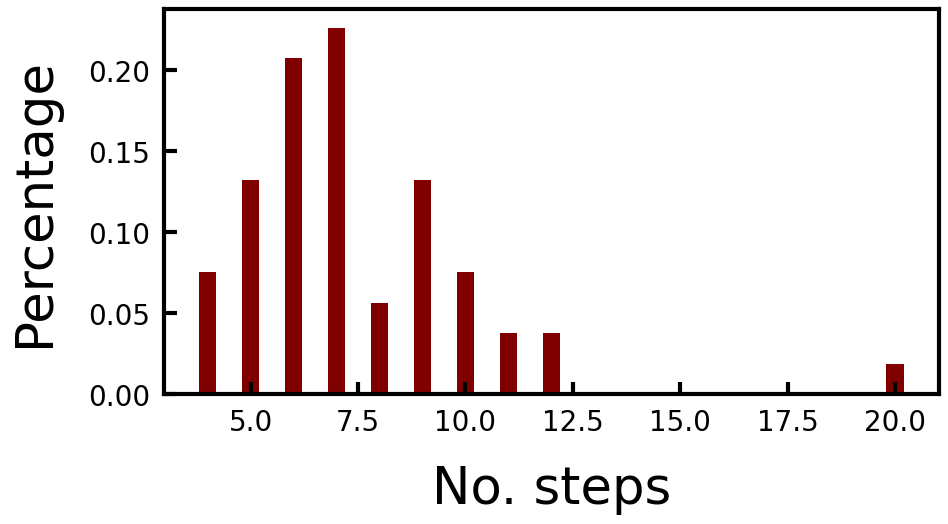

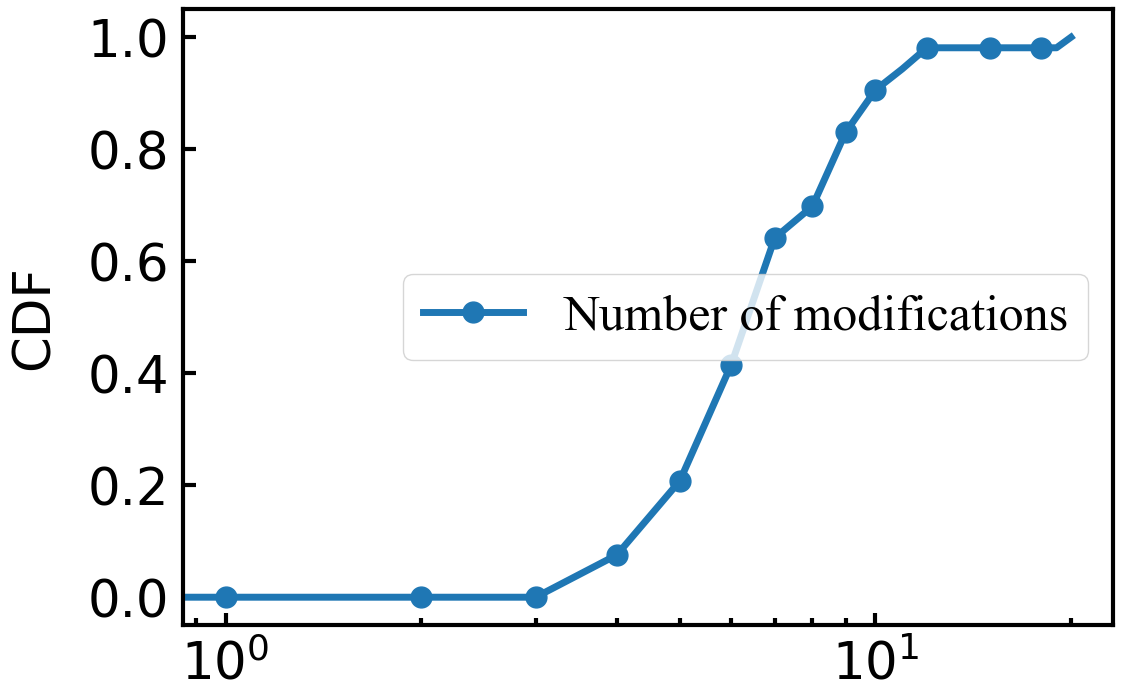

In [571]:
# RQ2, evolvement of STEP 1: number of steps (CoT)

num_steps_lst = []
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    codes_after_COT_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_COT_' + func_name + '.txt'
        
    num_steps, modification_needed, codes_lines = get_COT_feedback_corrected_codes_info_auto(func_name)
    
    num_steps_lst.append(num_steps)

    
x = [int(i.split('Number of steps: ')[1]) for i in num_steps_lst]
print()


    # plt.xlabel("No. of steps in the proposed step-by-step plan")
    # plt.ylabel(
    # plt.title()
    # plt.show()

    
    
xlabel = "No. steps"
ylabel = "Percentage"
title = "The percentage of codes that have each specific number of steps"
title = ''
save_as = 'RQ2_STEP1_COT_BAR_num_steps'


make_plot_of_counts(x, xlabel, ylabel, title, save_as)


x, y_kvic, y_non_kvic = get_cdf(x, x)

y_non_kvic = [i / max(y_non_kvic) for i in y_non_kvic]

y_kvic = [i / max(y_non_kvic) for i in y_non_kvic]
make_plot_cdf(x, y_kvic, y_kvic, 'RQ2_STEP1_COT_CDF_num_steps')


In [575]:
x[y_kvic.index( 0.6415094339622641)]

7

In [574]:
y_kvic

[0.0,
 0.0,
 0.0,
 0.0,
 0.07547169811320754,
 0.20754716981132076,
 0.41509433962264153,
 0.6415094339622641,
 0.6981132075471698,
 0.8301886792452831,
 0.9056603773584906,
 0.9433962264150944,
 0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 1.0]

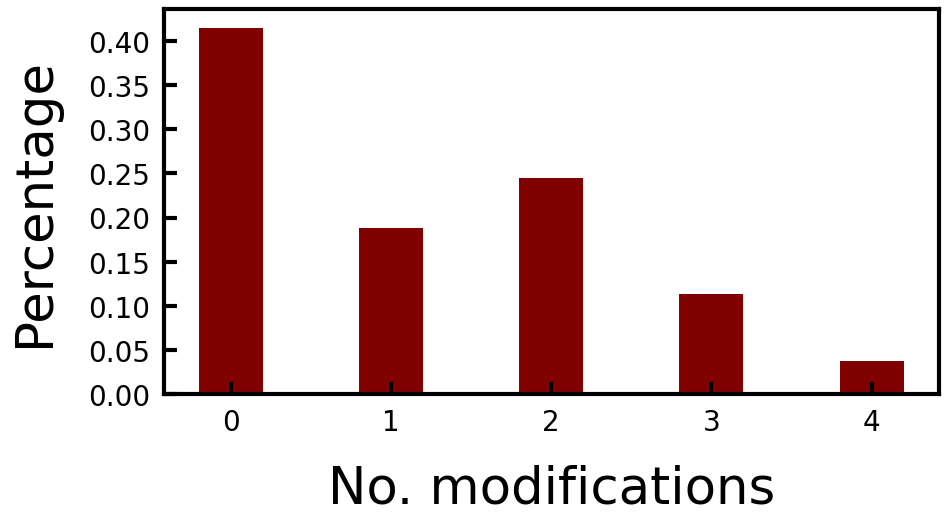

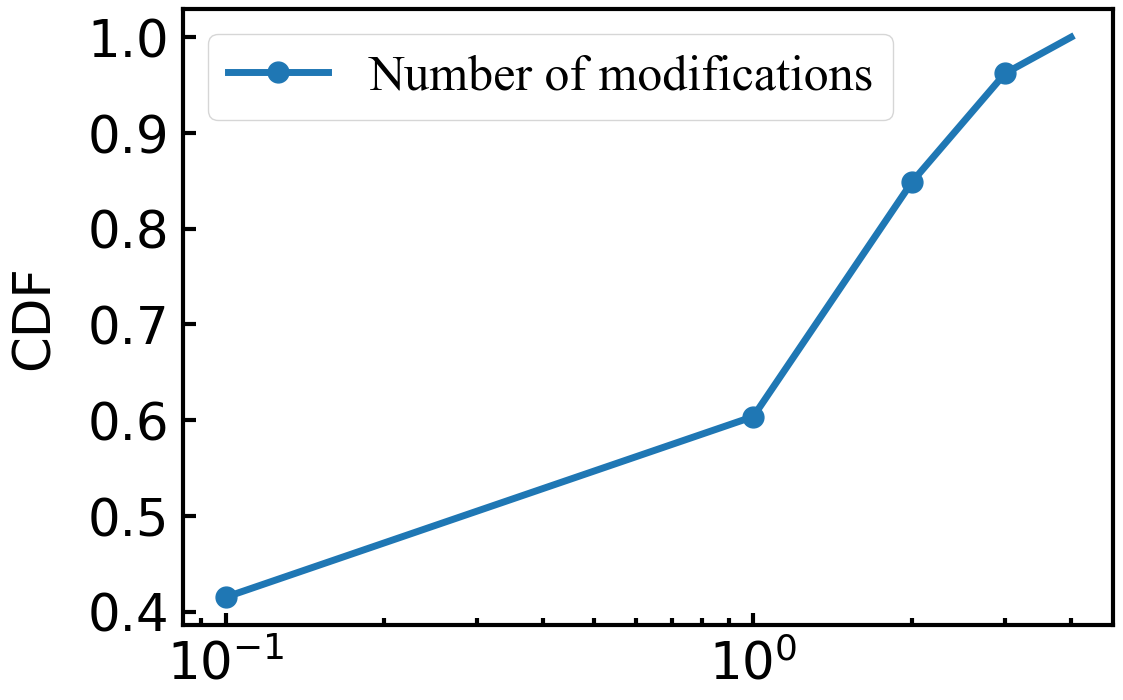

In [560]:
# RQ2, evolvement of STEP 2: the number of modification suggestions (FSE)

# Idea: count the number of modification suggestions that are proposed at each step


num_corrections_lst = []
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    codes_after_FSE_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_FEW_SHOT_EXAMPLE_' + func_name + '.txt'
        
    codes_after_FSE = read_from_file(codes_after_FSE_path)
    lines = codes_after_FSE.split('\n')
    correction_lines = [i for i in lines if i.strip().startswith('//MODIFICATION')]
    
    num_corrections_lst.append(len(correction_lines))

    
xlabel = "No. modifications"
ylabel = "Percentage"
title = "The percentage of codes that have each specific number of modifications"
title = ''
save_as = 'RQ2_STEP2_FSE_BAR_num_mods'



x = num_corrections_lst
# "No. of steps in the proposed step-by-step plan"
make_plot_of_counts(x, xlabel, ylabel, title, save_as)


x, y_kvic, y_non_kvic = get_cdf(x, x)
x = [0.1, 1, 2, 3, 4]

y_non_kvic = [i / max(y_non_kvic) for i in y_non_kvic]

y_kvic = [i / max(y_non_kvic) for i in y_non_kvic]
make_plot_cdf(x, y_kvic, y_kvic, 'RQ2_STEP2_FSE_CDF_num_mods')


In [554]:
x

[0, 1, 2, 3, 4]

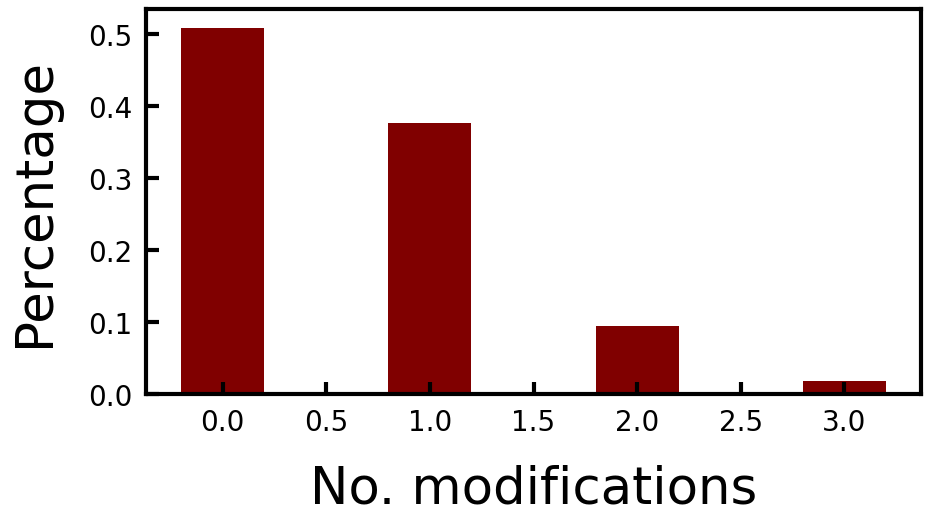

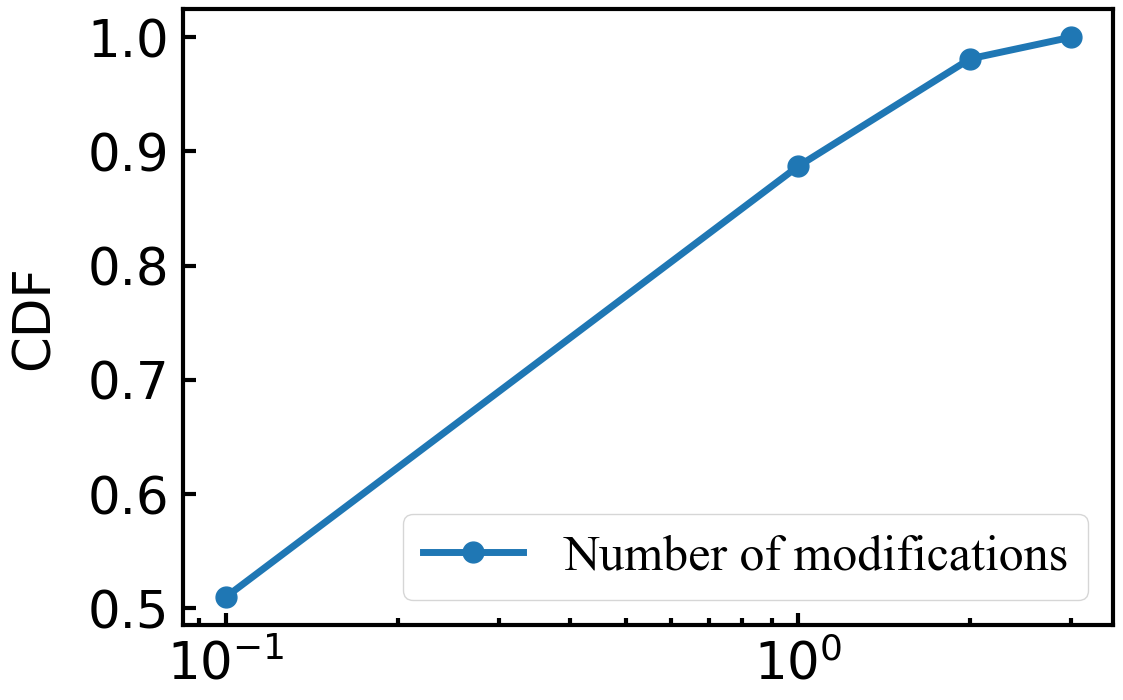

In [565]:
# RQ2, evolvement of STEP 3: RF

# Idea: count the number of modification suggestions that are proposed at each step


num_corrections_lst = []
for func_name in func_name_key_set:
    
    if func_name not in list_of_long_enough_functions:
        continue
        
    codes_after_RF_path = 'prompts_folder/new_function_dataset_builder/deduplicated_by_func_name/' + 'CODES_AFTER_CALLED_SIMILAR_FN_' + func_name + '.txt'
        
    codes_after_RF = read_from_file(codes_after_RF_path)
    lines = codes_after_RF.split('\n')
    correction_lines = [i for i in lines if i.strip().startswith('//CHANGES BASED ON CALLED CODE MADE')]
    
    num_corrections_lst.append(len(correction_lines))

    
xlabel = "No. modifications"
ylabel = "Percentage"
title = "The percentage of codes that have each specific number of modifications"
title = ''
save_as = 'RQ2_STEP3_RE_BAR_num_mods'



x = num_corrections_lst
# "No. of steps in the proposed step-by-step plan"
make_plot_of_counts(x, xlabel, ylabel, title, save_as)


x, y_kvic, y_non_kvic = get_cdf(x, x)
x = [0.1, 1, 2, 3]

y_non_kvic = [i / max(y_non_kvic) for i in y_non_kvic]

y_kvic = [i / max(y_non_kvic) for i in y_non_kvic]
make_plot_cdf(x, y_kvic, y_kvic, 'RQ2_STEP3_RE_CDF_num_mods')

In [564]:
x

[0, 1, 2, 3]

In [ ]:
# now we are ready to extract some contexual function



In [ ]:
# also apply 

# Note: although this method relies on having some contexual information provided and extracted, 
# it could still be generalized to cases like:
# 1. code generation from scracth
# 2. the contexual information could be easily tuned to customarily fit to certain tasks. Our method is quite general
#.   since contexual functions that are called or similar functions could be easily obtained.


# note: to what extent does our generated codes result reply on existing codes?
# note: our generated codes do not have to be perfect, but we just need to show that our modules collectively or individually have the
#.    effect of making improvements.